In [128]:
pip install pmdarima

Note: you may need to restart the kernel to use updated packages.


In [129]:
pip install dateparser

Note: you may need to restart the kernel to use updated packages.


In [130]:
from sklearn.model_selection import train_test_split
from sklearn_pandas import DataFrameMapper, cross_val_score              # what are these 
from sklearn.feature_extraction.text import TfidfVectorizer           
import pandas as pd
from sklearn.preprocessing import StandardScaler, LabelEncoder           # standardisation and label encoding 

from statsmodels.tsa.arima_model import ARIMA                            # arima model

import numpy as np, pandas as pd
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf            # acf and pacf
import matplotlib.pyplot as plt
plt.rcParams.update({'figure.figsize':(9,7), 'figure.dpi':120})          # default plot size and figure dpi   

from statsmodels.tsa.arima_model import ARIMA                            # ARima 
import pmdarima as pm                                                    # for sarimax I guess or auto arima
import statsmodels.api as sm

import dateparser

from statsmodels.tsa.seasonal import seasonal_decompose

# Studying hourly data 

In [131]:
df1 = pd.read_csv("../input/timeseries/Train.csv")
df1.head()

,ID,Datetime,Count
0,0,25-08-2012 00:00,8
1,1,25-08-2012 01:00,2
2,2,25-08-2012 02:00,6
3,3,25-08-2012 03:00,2
4,4,25-08-2012 04:00,2


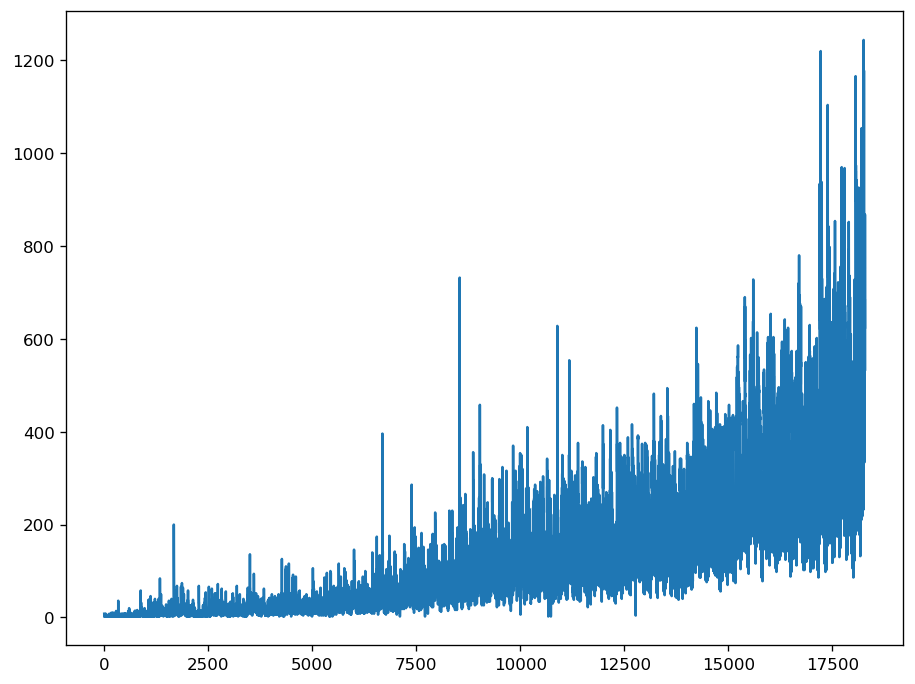

In [132]:
plt.plot(df1['Count'])

# Converting Data from Hourly to daywise

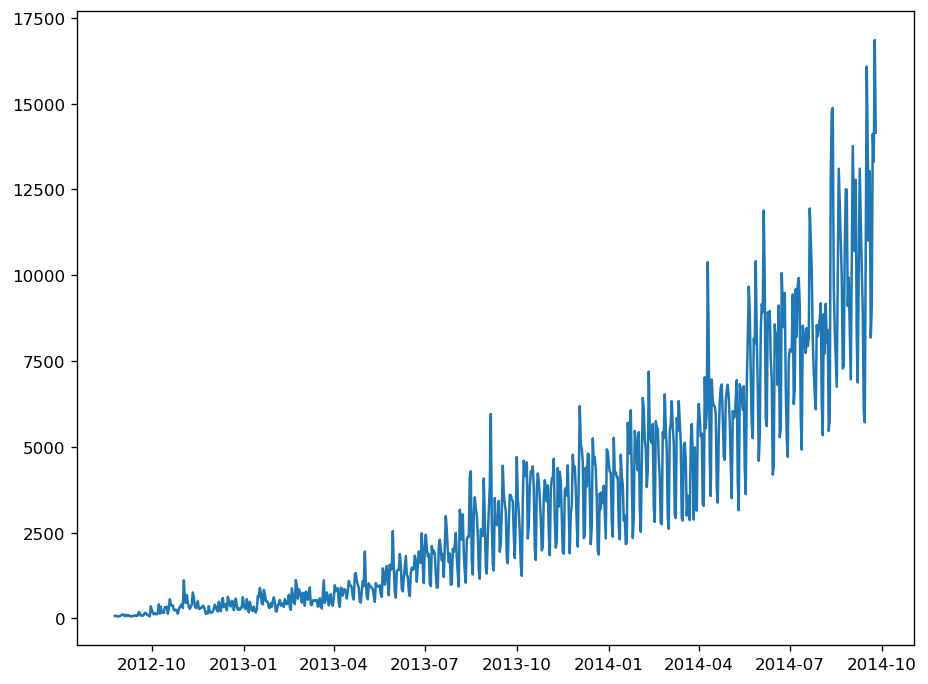

In [133]:
df = pd.read_csv("../input/timeseries/Train.csv")
df['Datetime'] = pd.to_datetime(df['Datetime'],format = '%d-%m-%Y %H:%M')
df['date'] = df['Datetime'].dt.date
df = df.groupby(['date'])['Count'].sum().reset_index()  # adding all the data given to get to total value per day
df = df.set_index('date')                      # setting the index using the date

plt.plot(df.index, df.Count)

# Calculating mean contribution of every hour of the day towards daily count 

[0.04428658786604787, 0.03534301407251346, 0.029911075818115848, 0.024714453347268642, 0.02080223006957949, 0.018621427272863207, 0.020023090853141697, 0.023221496687084307, 0.02674100231931643, 0.034555217753670806, 0.04904720717941372, 0.05437526020495296, 0.0549513510195312, 0.04860018589159891, 0.05196543769916253, 0.05130907193501191, 0.049999488443948796, 0.05116426222205782, 0.05242347711731082, 0.05562660500711062, 0.05345524632210873, 0.04989481620578089, 0.05007582834697351, 0.04889216634543569]


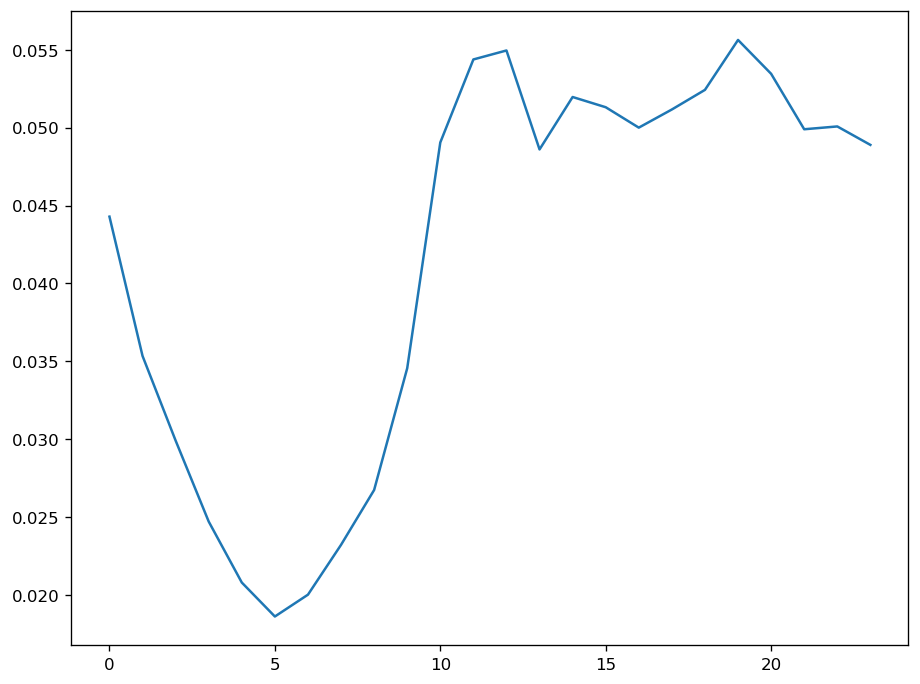

In [134]:
arr=np.array(df1['Count']).reshape(-1,24)
sum1=np.mean(arr,axis=0)
sum2=sum1/np.sum(sum1)
plt.plot(sum2)
print(list(sum2))

# Understanding the features of time series with the help of decomposition and ACF, PACF plots

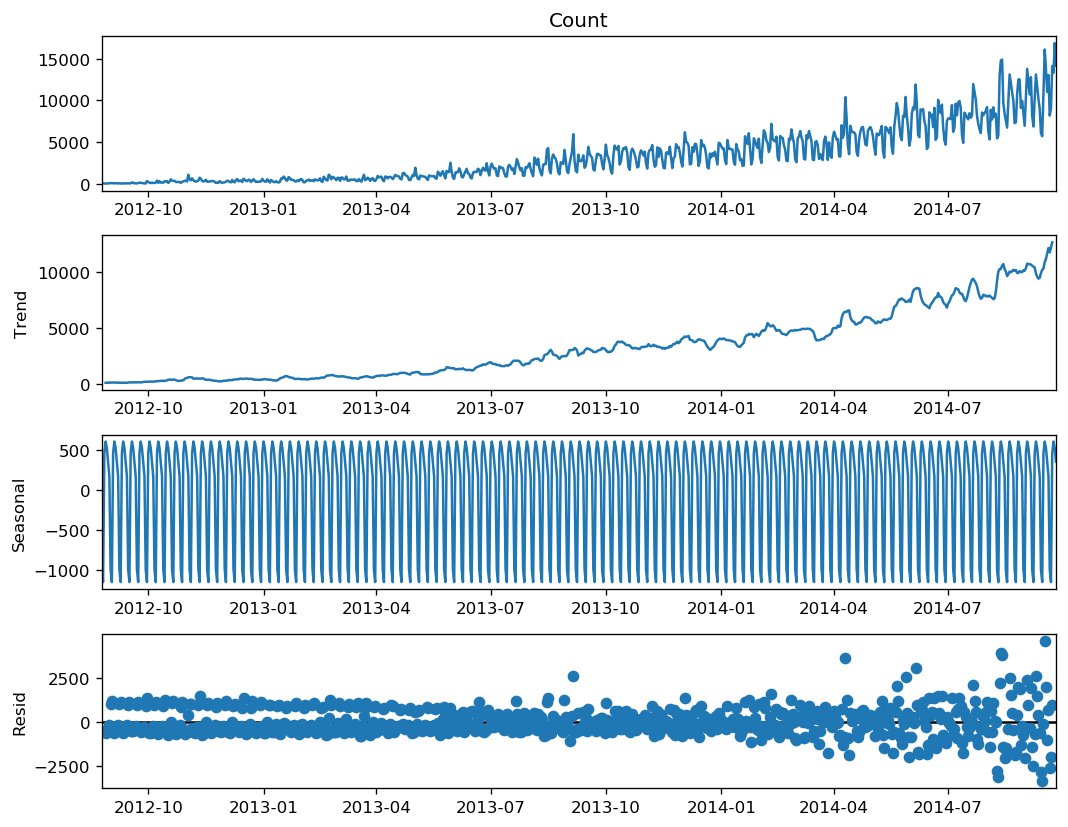

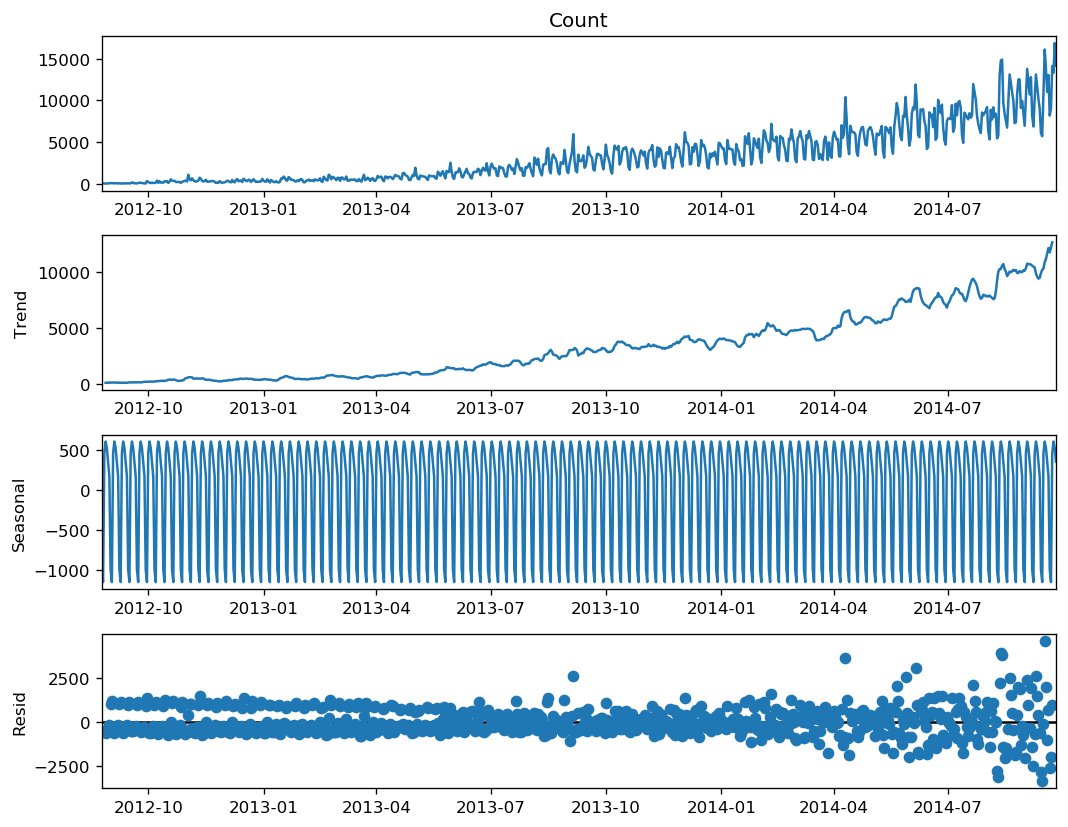

In [135]:
result = seasonal_decompose(df.Count, model='additive', period=7)

result.plot()

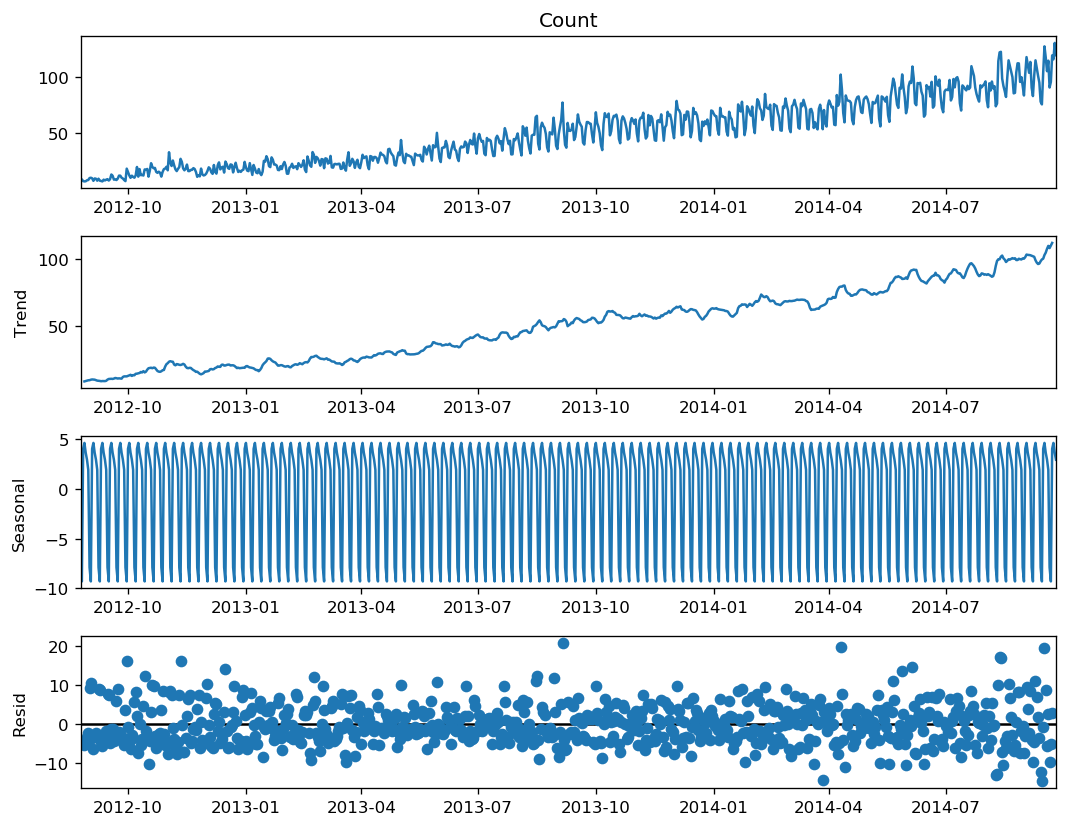

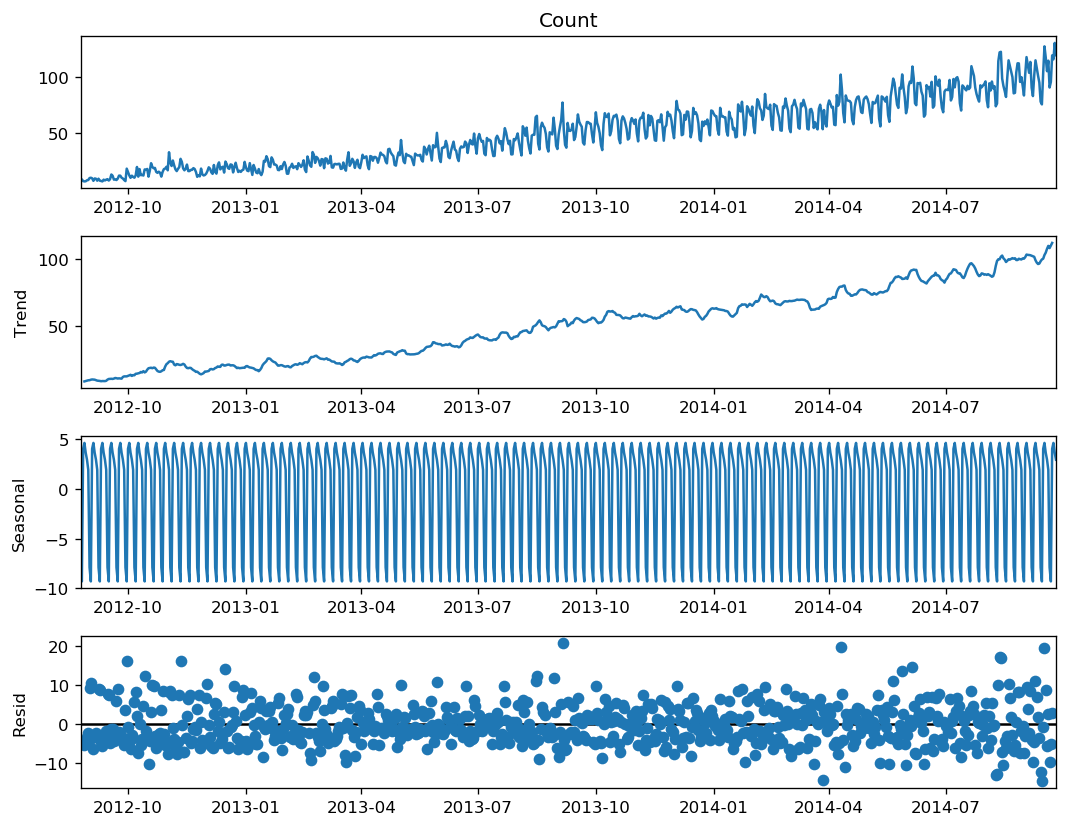

In [136]:
result = seasonal_decompose(np.sqrt(df.Count), model='additive', period=7)

result.plot()

# ACF plot

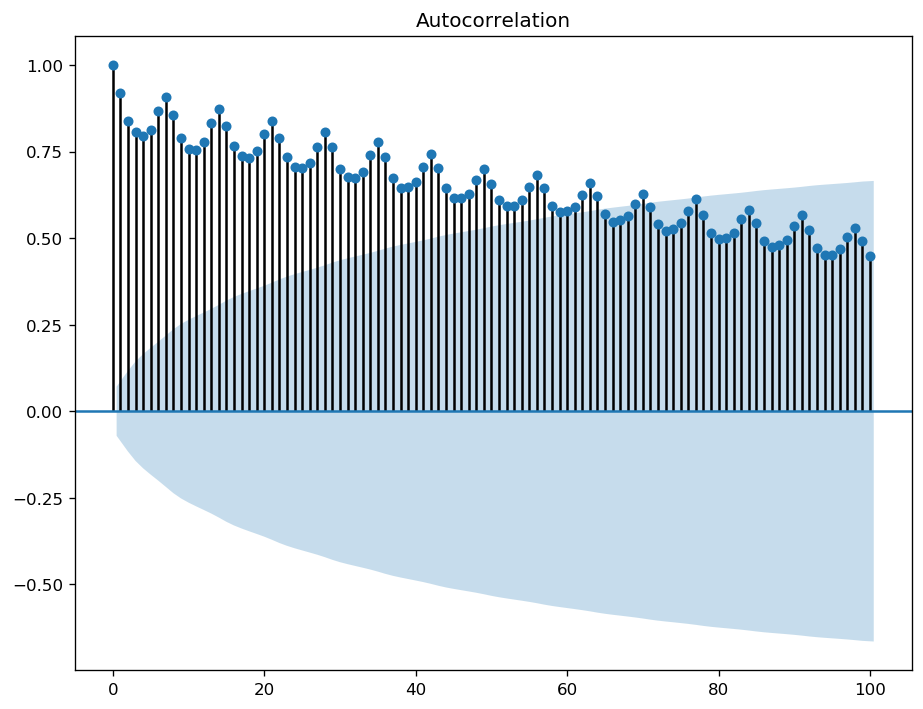

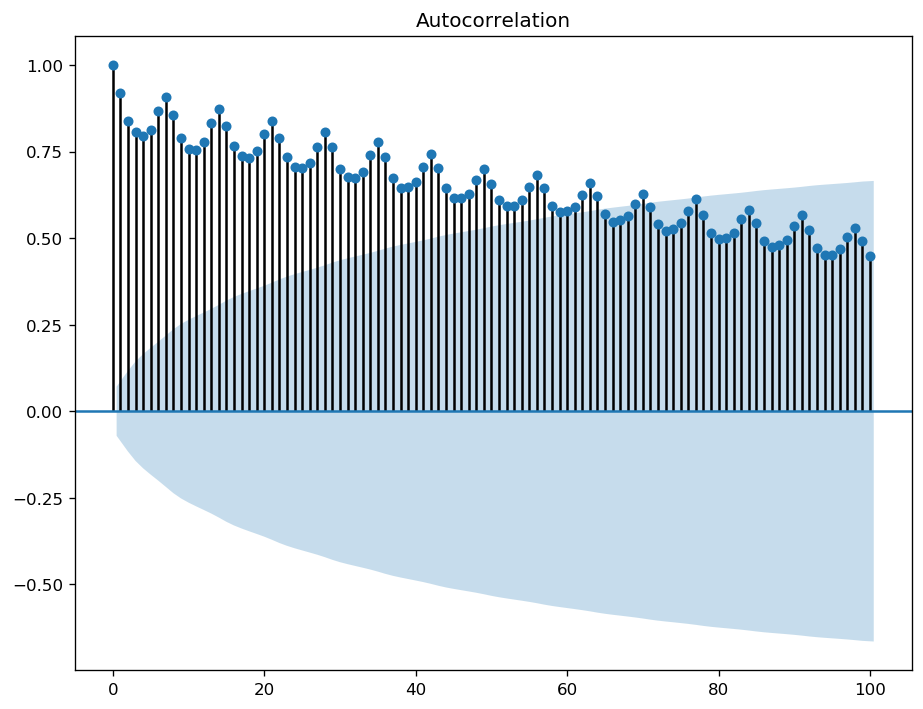

In [137]:
result = plot_acf(df.Count,lags=100)

result

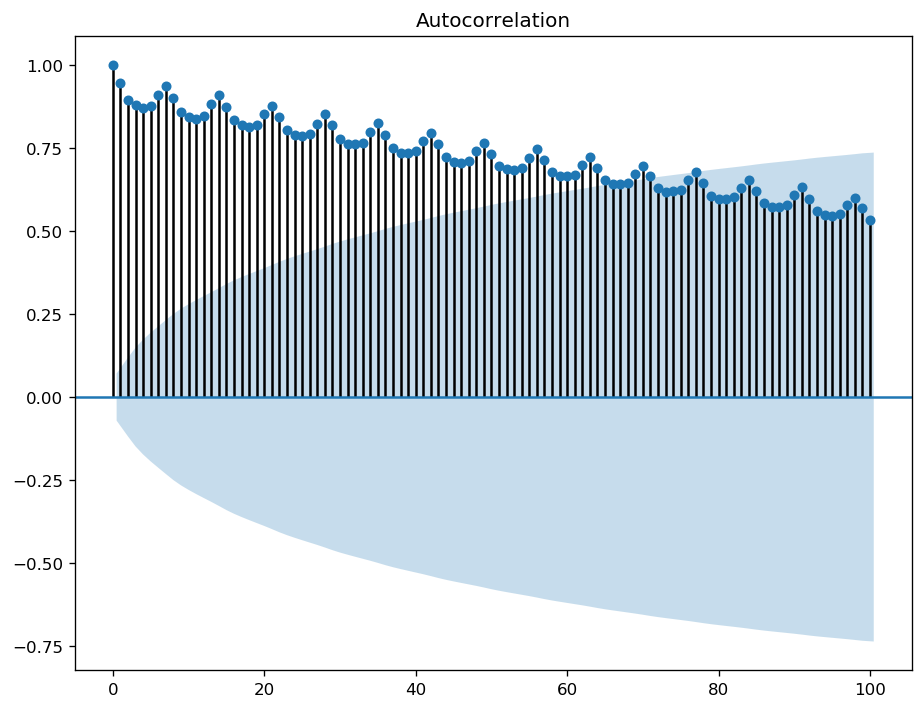

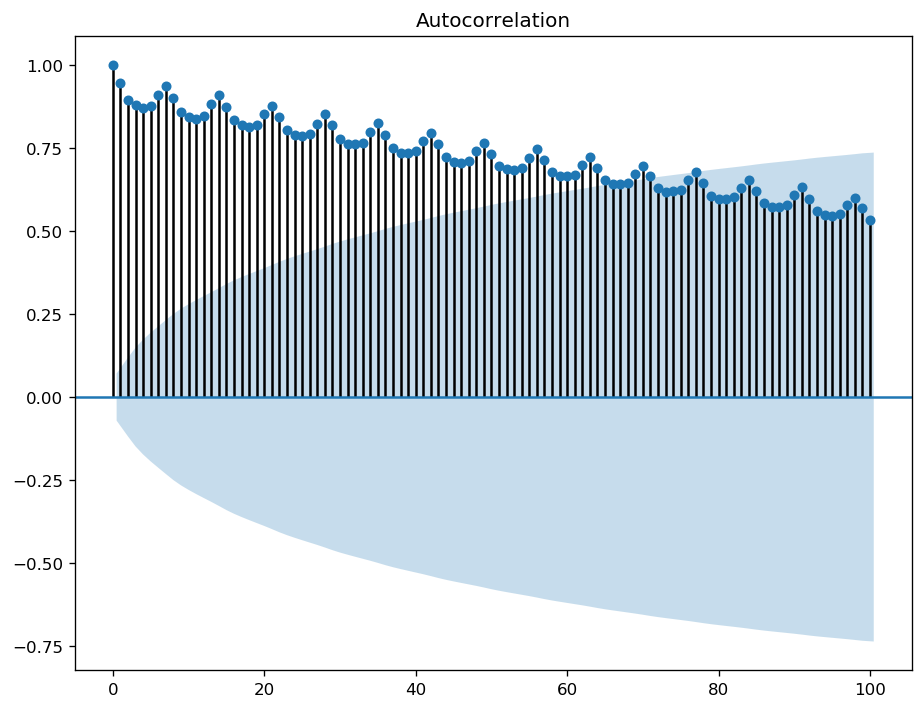

In [138]:
result = plot_acf(np.sqrt(df.Count),lags=100)   # result after taking sqrt of original count data # 

result

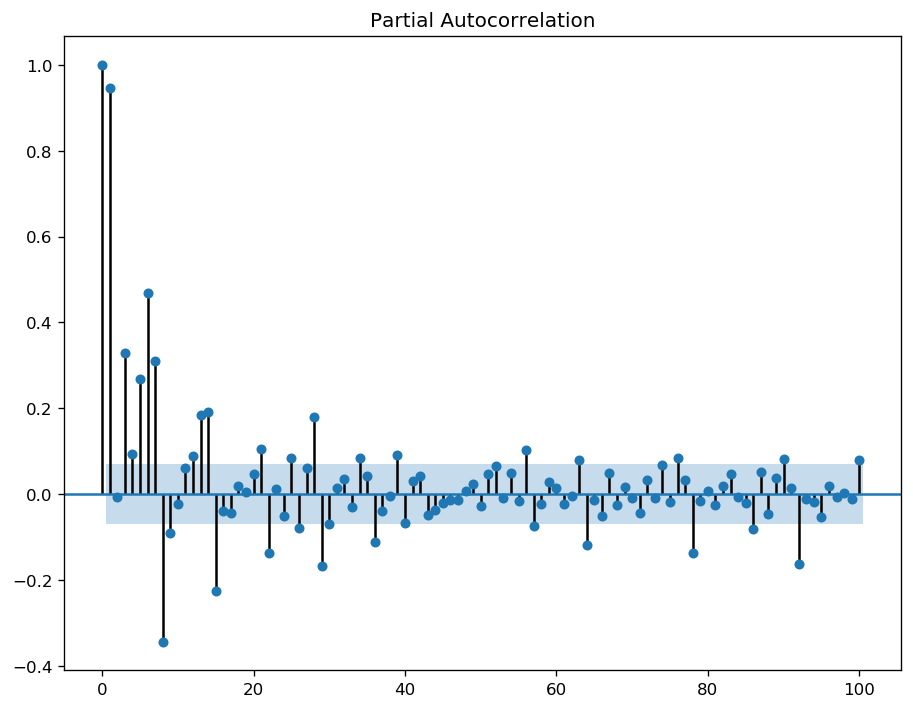

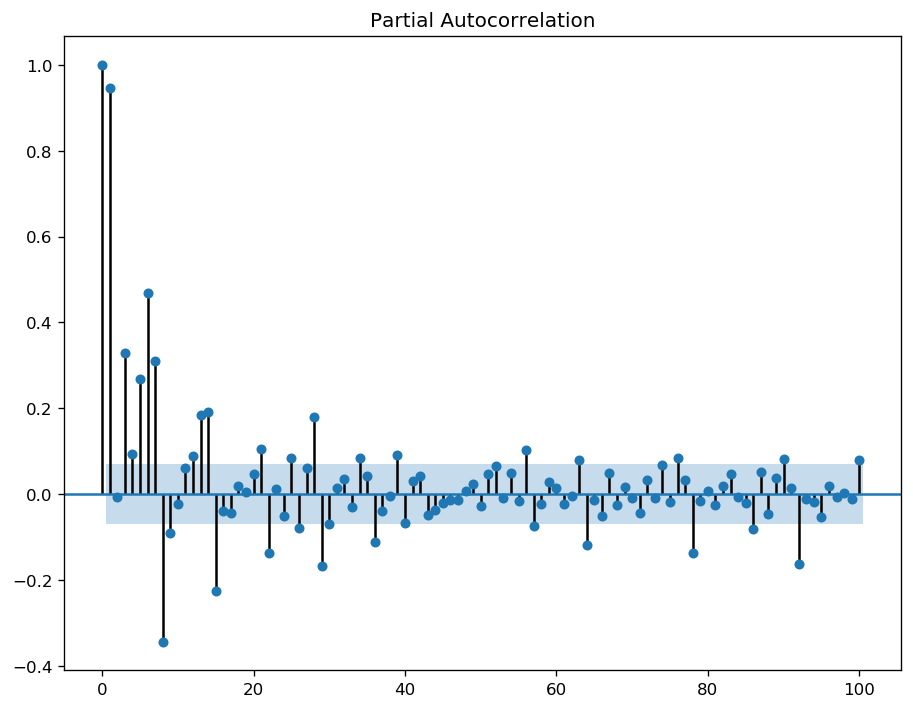

In [139]:
result = plot_pacf(np.sqrt(df.Count),lags=100)   # result after taking sqrt of original count data # 

result

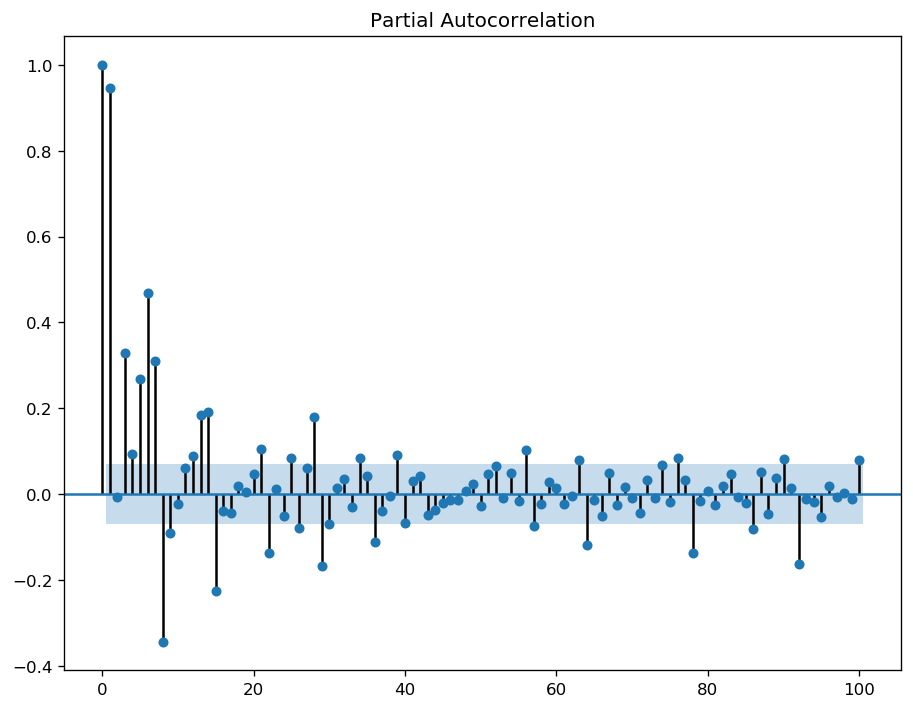

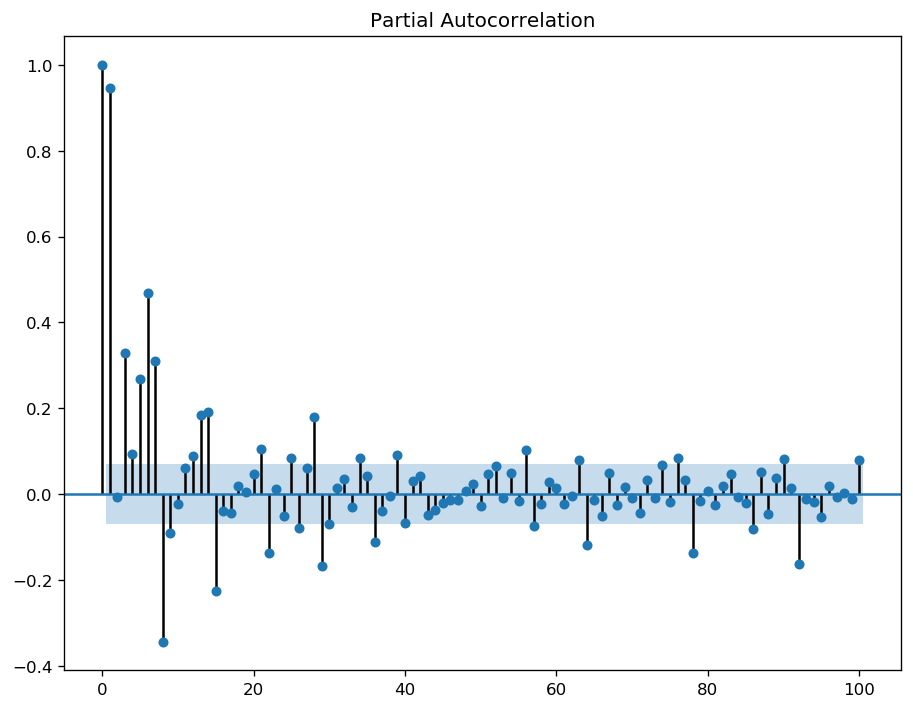

In [140]:
result = plot_pacf(np.sqrt(df.Count),lags=100)   # result after taking sqrt of original count data # 

result

## Observations : we see that ACF is decaying with lags and PACF abruptly becomes insignificant after some lags. This combination suggests that the time series have both AR and MA components

## : We also observe some kind of periodicity in the PACF and ACF which seems to be weekly. Hence it can be concluded that the time series has seasonlity effect as well.

## we will start exploring in the following order 

   ## (1) AR (2) MA (3) AR with differencing (4) MA with differencing 
   ## (5) ARMA (6) ARIMA (ARMA with differencing) (7) SARIMA ( initial model (8) SARIMA ( after hyperparameter tuning of p,q,d,P,Q,D,s )
   

# We can see that index ( no. of days is from 0 to 761 )
# Now Applying AR model to make forcasting for start day 762 to end day 974 #

# Using AR(7) with no seasonlity effect 

In [141]:
mod = sm.tsa.statespace.SARIMAX((df.Count), order=(7,0,0), seasonal_order=(0,0,0,0))
results = mod.fit()
print(results.summary())

a_preds_AR = results.predict(start = 762, end= 974, dynamic= True)
preds_old_AR = results.predict(start = 0, end= 761, dynamic= False)
print(a_preds_AR.sum())

/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:963: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


                               SARIMAX Results                                
Dep. Variable:                  Count   No. Observations:                  762
Model:               SARIMAX(7, 0, 0)   Log Likelihood               -6214.572
Date:                Thu, 14 May 2020   AIC                          12445.144
Time:                        17:46:23   BIC                          12482.231
Sample:                    08-25-2012   HQIC                         12459.424
                         - 09-25-2014                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4748      0.021     22.409      0.000       0.433       0.516
ar.L2         -0.1823      0.025     -7.406      0.000      -0.231      -0.134
ar.L3          0.1212      0.024      5.020      0.0

Text(0.5, 1.0, 'AR(7) with no seasonlity affect')

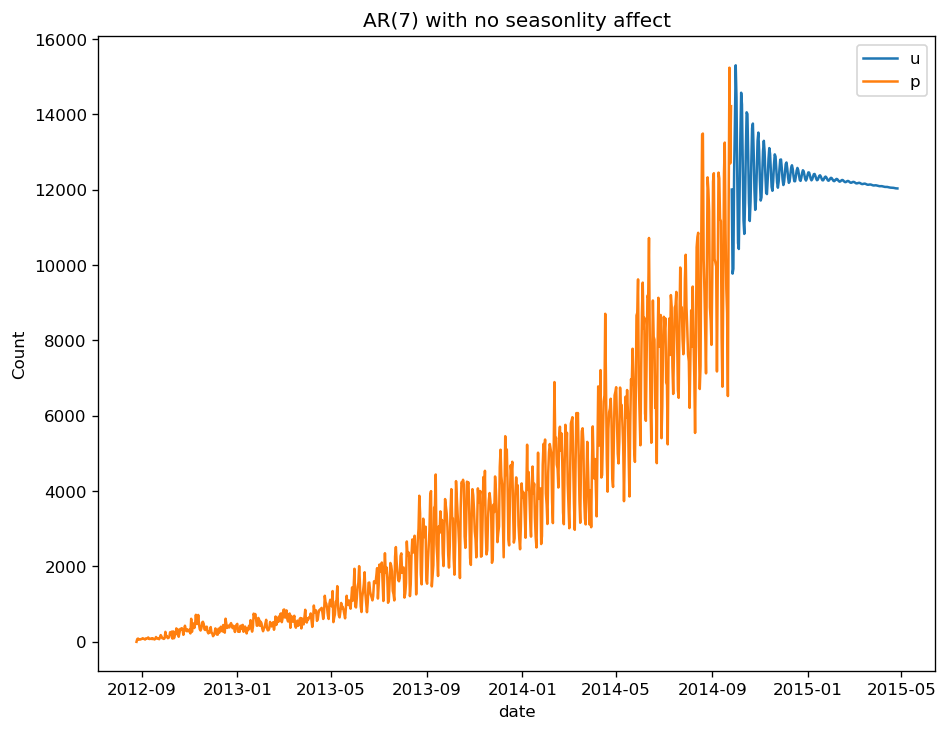

In [142]:
plt.plot(a_preds_AR,label='test')
plt.plot(preds_old_AR,label='train')
plt.legend('upperleft')
plt.xlabel('date')
plt.ylabel('Count')
plt.title('AR(7) with no seasonlity affect')

# Now Applying MA model to make forcasting for start day 762 to end day 974 #

# Using MA(7) with no seasonlity effect 

In [143]:
mod = sm.tsa.statespace.SARIMAX((df.Count), order=(0,0,7), seasonal_order=(0,0,0,0))
results = mod.fit()
print(results.summary())

a_preds_MA = results.predict(start = 762, end= 974, dynamic= True)
preds_old_MA = results.predict(start = 0, end= 761, dynamic= False)
print(a_preds_MA.sum())

/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


                               SARIMAX Results                                
Dep. Variable:                  Count   No. Observations:                  762
Model:               SARIMAX(0, 0, 7)   Log Likelihood               -6740.774
Date:                Thu, 14 May 2020   AIC                          13497.547
Time:                        17:46:26   BIC                          13534.635
Sample:                    08-25-2012   HQIC                         13511.827
                         - 09-25-2014                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          1.4130      0.026     55.071      0.000       1.363       1.463
ma.L2          1.2599      0.051     24.825      0.000       1.160       1.359
ma.L3          1.2879      0.063     20.484      0.0

/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Text(0.5, 1.0, 'MA(7) with no seasonlity affect')

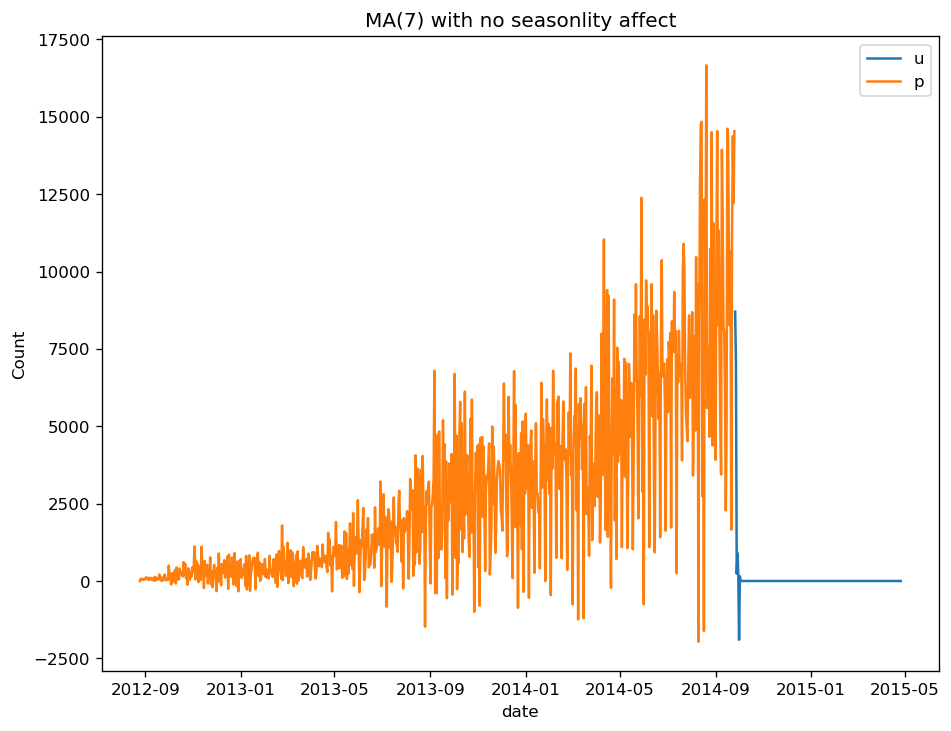

In [144]:
plt.plot(a_preds_MA,label='test')
plt.plot(preds_old_MA,label='train')
plt.legend('upperleft')
plt.xlabel('date')
plt.ylabel('Count')
plt.title('MA(7) with no seasonlity affect')

# Now Applying AR(7) with differencing model to make forcasting for start day 762 to end day 974 #

# Using AR(7) with differencing with no seasonlity effect 

In [145]:
mod = sm.tsa.statespace.SARIMAX((df.Count), order=(7,1,0), seasonal_order=(0,0,0,0))
results = mod.fit()
print(results.summary())

a_preds_AR_diff = results.predict(start = 762, end= 974, dynamic= True)
preds_old_AR_diff = results.predict(start = 0, end= 761, dynamic= False)
print(a_preds_AR_diff.sum())

/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


                               SARIMAX Results                                
Dep. Variable:                  Count   No. Observations:                  762
Model:               SARIMAX(7, 1, 0)   Log Likelihood               -6179.138
Date:                Thu, 14 May 2020   AIC                          12374.277
Time:                        17:46:26   BIC                          12411.354
Sample:                    08-25-2012   HQIC                         12388.554
                         - 09-25-2014                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4099      0.021    -19.438      0.000      -0.451      -0.369
ar.L2         -0.5380      0.023    -22.975      0.000      -0.584      -0.492
ar.L3         -0.4285      0.024    -18.057      0.0

Text(0.5, 1.0, 'AR(7) with differencing with no seasonlity affect')

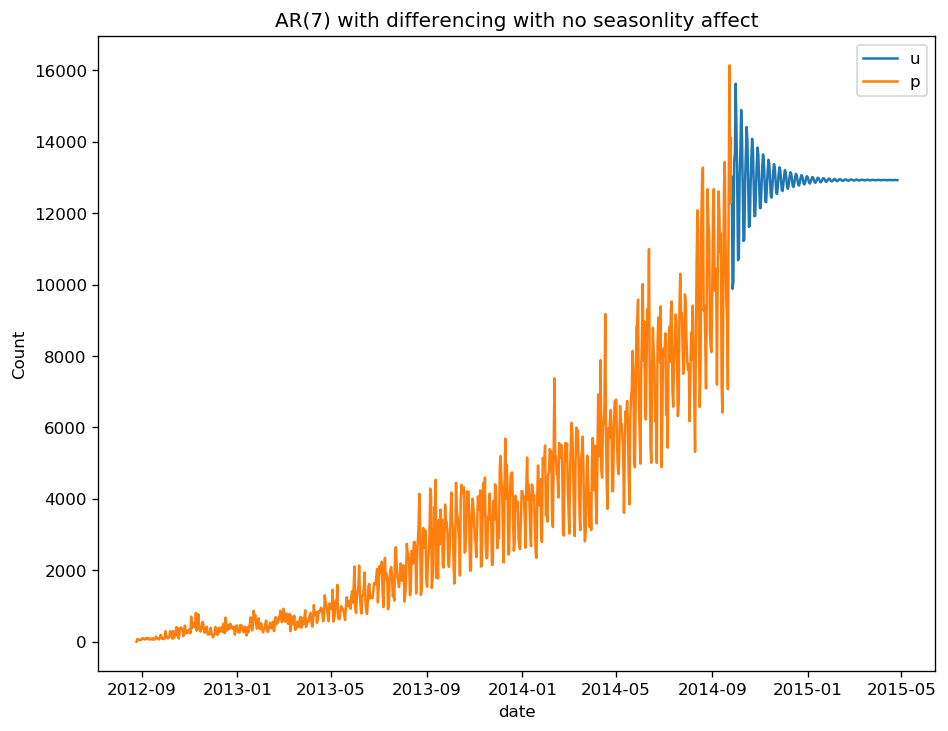

In [146]:
plt.plot(a_preds_AR_diff,label='test')
plt.plot(preds_old_AR_diff,label='train')
plt.legend('upperleft')
plt.xlabel('date')
plt.ylabel('Count')
plt.title('AR(7) with differencing with no seasonlity affect')

# Now Applying ARMA(7,7) with differencing model to make forcasting for start day 762 to end day 974
# Using ARMA(7,7) with differencing with no seasonlity effect

In [147]:
mod = sm.tsa.statespace.SARIMAX((df.Count), order=(7,0,7), seasonal_order=(0,0,0,0))
results = mod.fit()
print(results.summary())

a_preds_ARMA = results.predict(start = 762, end= 974, dynamic= True)
preds_old_ARMA = results.predict(start = 0, end= 761, dynamic= False)
print(a_preds_ARMA.sum())

/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:963: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


                               SARIMAX Results                                
Dep. Variable:                  Count   No. Observations:                  762
Model:               SARIMAX(7, 0, 7)   Log Likelihood               -6107.967
Date:                Thu, 14 May 2020   AIC                          12245.933
Time:                        17:46:31   BIC                          12315.472
Sample:                    08-25-2012   HQIC                         12272.708
                         - 09-25-2014                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0085      0.011      0.760      0.447      -0.013       0.031
ar.L2          0.0106      0.010      1.073      0.283      -0.009       0.030
ar.L3         -0.0233      0.009     -2.648      0.0

/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Text(0.5, 1.0, 'ARMA(7,7) with differencing with no seasonlity affect')

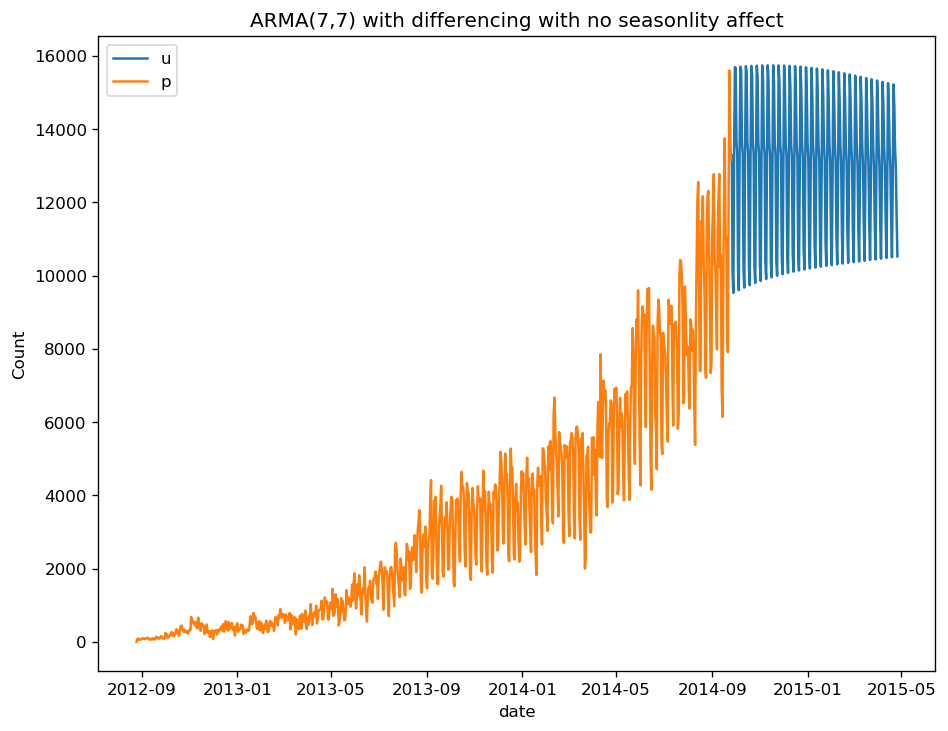

In [148]:
plt.plot(a_preds_ARMA,label='test')
plt.plot(preds_old_ARMA,label='train')
plt.legend('upperleft')
plt.xlabel('date')
plt.ylabel('Count')
plt.title('ARMA(7,7) with differencing with no seasonlity affect')

# Now Applying ARMA(7,7) with differencing model = ARIMA(7,1,7) to make forcasting for start day 762 to end day 974
# Using ARIMA(7,1,7) with differencing with no seasonlity effect

In [149]:
mod = sm.tsa.statespace.SARIMAX((df.Count), order=(7,1,7), seasonal_order=(0,0,0,0))
results = mod.fit()
print(results.summary())

a_preds_ARIMA = results.predict(start = 762, end= 974, dynamic= True)
preds_old_ARIMA = results.predict(start = 0, end= 761, dynamic= False)
print(a_preds_ARIMA.sum())

/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:963: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


                               SARIMAX Results                                
Dep. Variable:                  Count   No. Observations:                  762
Model:               SARIMAX(7, 1, 7)   Log Likelihood               -6118.529
Date:                Thu, 14 May 2020   AIC                          12267.057
Time:                        17:46:36   BIC                          12336.577
Sample:                    08-25-2012   HQIC                         12293.826
                         - 09-25-2014                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7089      0.115     -6.171      0.000      -0.934      -0.484
ar.L2         -0.4321      0.049     -8.903      0.000      -0.527      -0.337
ar.L3         -0.8989      0.078    -11.582      0.0

/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Text(0.5, 1.0, 'ARIMA(7,1,7) with differencing with no seasonlity affect')

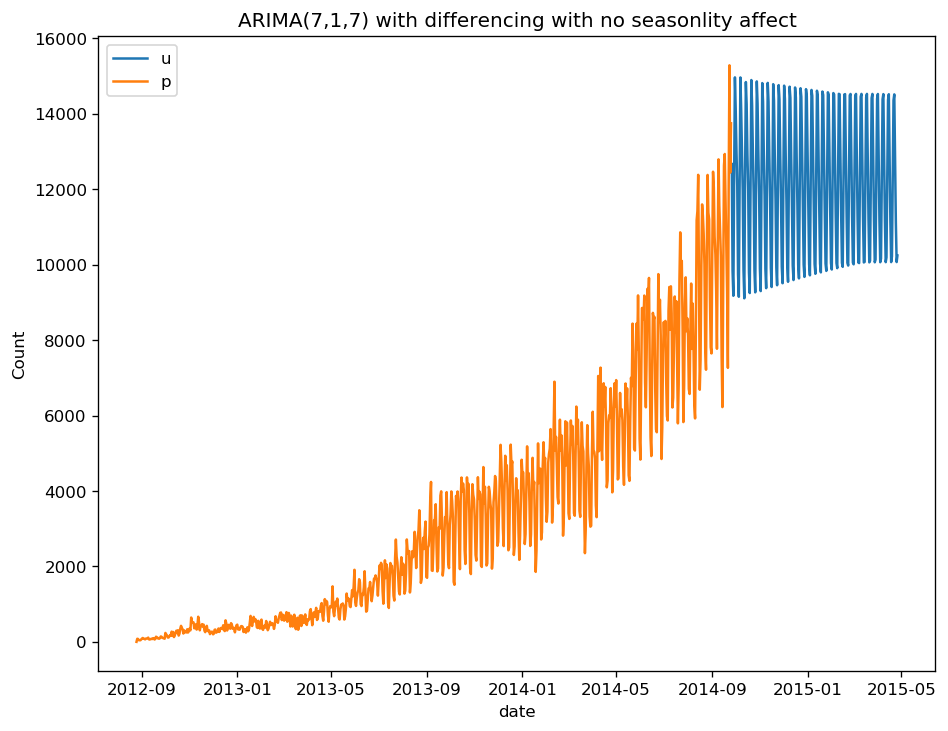

In [150]:
plt.plot(a_preds_ARIMA,label='test')
plt.plot(preds_old_ARIMA,label='train')
plt.legend('upperleft')
plt.xlabel('date')
plt.ylabel('Count')
plt.title('ARIMA(7,1,7) with differencing with no seasonlity affect')

# Now Applying Seasonal ARIMA(1,1,1),(1,1,1,7) to make forcasting for start day 762 to end day 974

In [151]:
mod = sm.tsa.statespace.SARIMAX((df.Count), order=(1,1,1), seasonal_order=(1,1,1,7))
results = mod.fit()
print(results.summary())

a_preds_SARIMA = results.predict(start = 762, end= 974, dynamic= True)
preds_old_SARIMA = results.predict(start = 0, end= 761, dynamic= False)
print(a_preds_SARIMA.sum())

/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


                                     SARIMAX Results                                     
Dep. Variable:                             Count   No. Observations:                  762
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 7)   Log Likelihood               -6025.043
Date:                           Thu, 14 May 2020   AIC                          12060.087
Time:                                   17:46:39   BIC                          12083.214
Sample:                               08-25-2012   HQIC                         12068.996
                                    - 09-25-2014                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5619      0.019     29.805      0.000       0.525       0.599
ma.L1         -0.9998      0.017    -59.358

<function matplotlib.pyplot.show(*args, **kw)>

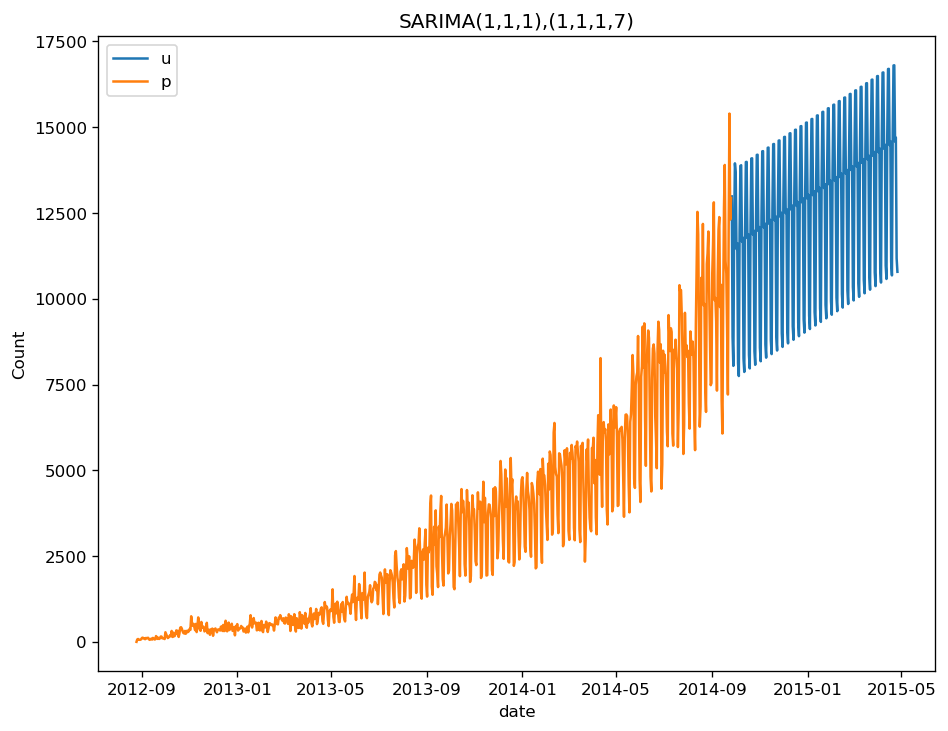

In [152]:
plt.plot(a_preds_SARIMA,label='test')
plt.plot(preds_old_SARIMA,label='train')
plt.legend('upperleft')
plt.xlabel('date')
plt.ylabel('Count')
plt.title('SARIMA(1,1,1),(1,1,1,7)')
plt.show

# Now Applying Seasonal ARIMA(1,1,1),(1,1,1,7) to make forcasting for start day 762 to end day 974 on data with log transformation

In [153]:
mod = sm.tsa.statespace.SARIMAX(np.log(df.Count), order=(1,1,1), seasonal_order=(1,1,1,7))
results = mod.fit()
print(results.summary())

a_preds_SARIMA = results.predict(start = 762, end= 974, dynamic= True)
preds_old_SARIMA = results.predict(start = 0, end= 761, dynamic= False)
print(a_preds_SARIMA.sum())

/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


                                     SARIMAX Results                                     
Dep. Variable:                             Count   No. Observations:                  762
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 7)   Log Likelihood                  13.001
Date:                           Thu, 14 May 2020   AIC                            -16.003
Time:                                   17:46:41   BIC                              7.124
Sample:                               08-25-2012   HQIC                            -7.094
                                    - 09-25-2014                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4212      0.033     12.904      0.000       0.357       0.485
ma.L1         -0.9178      0.015    -61.814

<function matplotlib.pyplot.show(*args, **kw)>

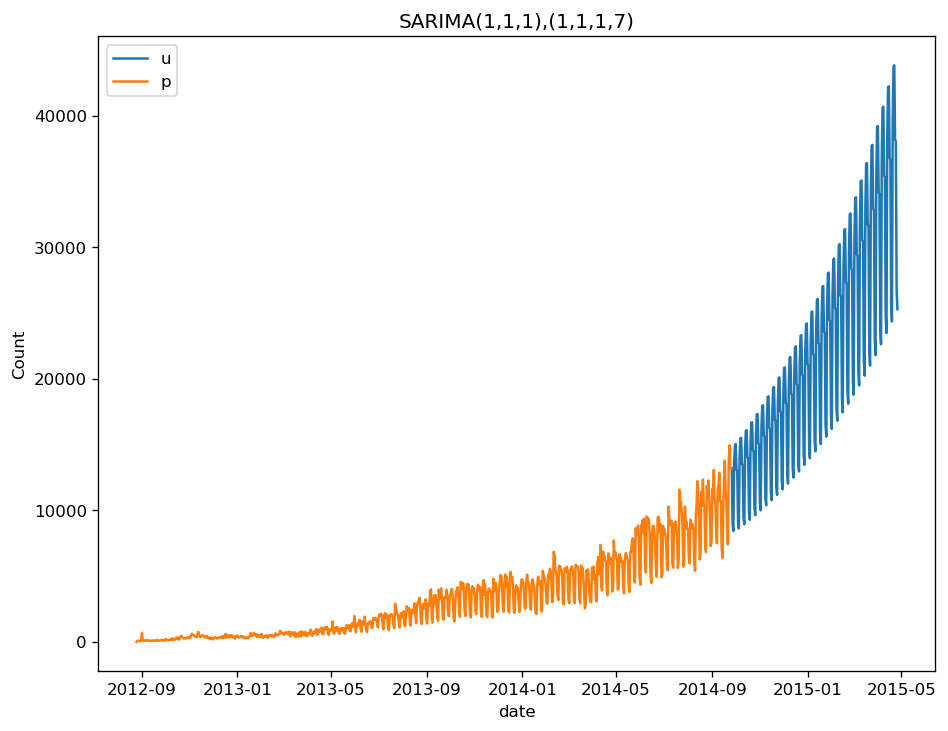

In [154]:
plt.plot(np.exp(a_preds_SARIMA),label='test')
plt.plot(np.exp(preds_old_SARIMA),label='train')
plt.legend('upperleft')
plt.xlabel('date')
plt.ylabel('Count')
plt.title('SARIMA(1,1,1),(1,1,1,7)')
plt.show

# Now Applying Seasonal ARIMA(1,1,1),(1,1,1,7) to make forcasting for start day 762 to end day 974 on data with sqrt transformation

In [155]:
mod = sm.tsa.statespace.SARIMAX(np.sqrt(df.Count), order=(1,1,1), seasonal_order=(1,1,1,7))
results = mod.fit()
print(results.summary())

a_preds_SARIMA = results.predict(start = 762, end= 974, dynamic= True)
preds_old_SARIMA = results.predict(start = 0, end= 761, dynamic= False)
print(a_preds_SARIMA.sum())

/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


                                     SARIMAX Results                                     
Dep. Variable:                             Count   No. Observations:                  762
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 7)   Log Likelihood               -2246.804
Date:                           Thu, 14 May 2020   AIC                           4503.608
Time:                                   17:46:42   BIC                           4526.735
Sample:                               08-25-2012   HQIC                          4512.517
                                    - 09-25-2014                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4814      0.030     16.039      0.000       0.423       0.540
ma.L1         -0.9702      0.011    -85.835

<function matplotlib.pyplot.show(*args, **kw)>

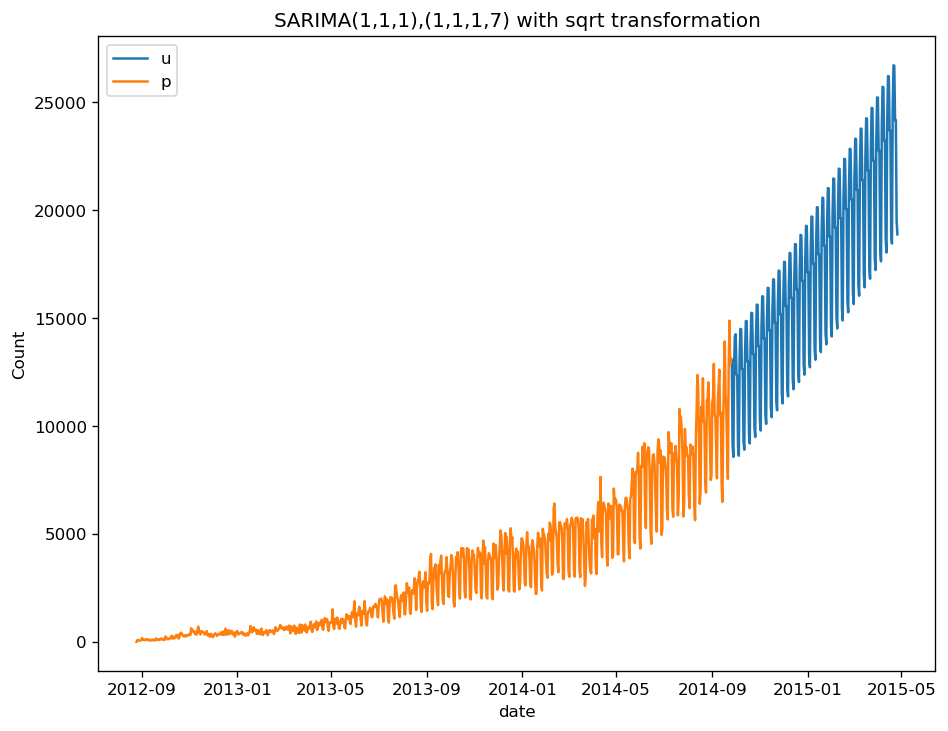

In [156]:
plt.plot(np.square(a_preds_SARIMA),label='test')
plt.plot(np.square(preds_old_SARIMA),label='train')
plt.legend('upperleft')
plt.xlabel('date')
plt.ylabel('Count')
plt.title('SARIMA(1,1,1),(1,1,1,7) with sqrt transformation')
plt.show

# now performing hyperparameter tuning to get to the best parameters for SARIMA model on data without any transformation and data with transformation 

# Hyperparameter tuning for data without transformation 

In [157]:
model = pm.auto_arima((df.Count), start_p=1, start_q=1,
                         test='adf',
                         max_p=6, max_q=6, m=7,
                         start_P=0, seasonal=True,
                         d=1, D=1, trace=True,stationary=False,
                         error_action='ignore',  
                         suppress_warnings=True,with_intercept=False, 
                         stepwise=True)

Performing stepwise search to minimize aic
Fit ARIMA(1,1,1)x(0,1,1,7) [intercept=False]; AIC=12027.019, BIC=12045.521, Time=2.895 seconds
Fit ARIMA(0,1,0)x(0,1,0,7) [intercept=False]; AIC=12591.215, BIC=12595.840, Time=0.035 seconds
Fit ARIMA(1,1,0)x(1,1,0,7) [intercept=False]; AIC=12347.822, BIC=12361.698, Time=0.481 seconds
Fit ARIMA(0,1,1)x(0,1,1,7) [intercept=False]; AIC=12124.556, BIC=12138.432, Time=1.087 seconds
Fit ARIMA(1,1,1)x(0,1,0,7) [intercept=False]; AIC=12379.535, BIC=12393.411, Time=0.551 seconds
Near non-invertible roots for order (1, 1, 1)(0, 1, 0, 7); setting score to inf (at least one inverse root too close to the border of the unit circle: 1.000)
Fit ARIMA(1,1,1)x(1,1,1,7) [intercept=False]; AIC=12060.087, BIC=12083.214, Time=2.422 seconds
Near non-invertible roots for order (1, 1, 1)(1, 1, 1, 7); setting score to inf (at least one inverse root too close to the border of the unit circle: 1.000)
Fit ARIMA(1,1,1)x(0,1,2,7) [intercept=False]; AIC=12028.810, BIC=12051.

In [158]:
mod = sm.tsa.statespace.SARIMAX((df.Count), order=model.order, seasonal_order=model.seasonal_order)
results = mod.fit()
print(results.summary())

a_preds_SARIMA_tuned = results.predict(start = 762, end= 974, dynamic= True)
preds_old_SARIMA_tuned = results.predict(start = 0, end= 761, dynamic= False)
print(a_preds_SARIMA_tuned.sum())

/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


                                      SARIMAX Results                                      
Dep. Variable:                               Count   No. Observations:                  762
Model:             SARIMAX(2, 1, 2)x(0, 1, [1], 7)   Log Likelihood               -6006.766
Date:                             Thu, 14 May 2020   AIC                          12025.532
Time:                                     17:48:21   BIC                          12053.284
Sample:                                 08-25-2012   HQIC                         12036.223
                                      - 09-25-2014                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1102      0.243     -0.453      0.650      -0.587       0.366
ar.L2          0.2603      

<function matplotlib.pyplot.show(*args, **kw)>

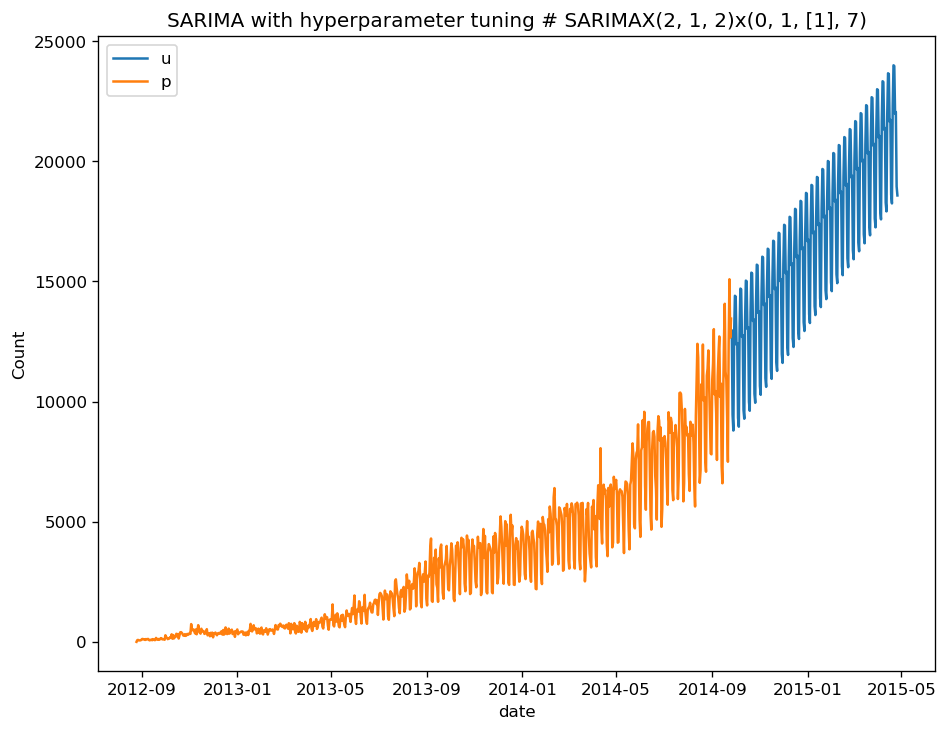

In [159]:
plt.plot(a_preds_SARIMA_tuned,label='test')
plt.plot(preds_old_SARIMA_tuned,label='train')
plt.legend('upperleft')
plt.xlabel('date')
plt.ylabel('Count')
plt.title('SARIMA with hyperparameter tuning # SARIMAX(2, 1, 2)x(0, 1, [1], 7)')
plt.show

# Hyperparameter tuning for SARIMA model with log transformation

In [160]:
model = pm.auto_arima(np.log(df.Count), start_p=1, start_q=1,
                         test='adf',
                         max_p=6, max_q=6, m=7,
                         start_P=0, seasonal=True,
                         d=1, D=1, trace=True,stationary=False,
                         error_action='ignore',  
                         suppress_warnings=True,with_intercept=False, 
                         stepwise=True)

Performing stepwise search to minimize aic
Fit ARIMA(1,1,1)x(0,1,1,7) [intercept=False]; AIC=-17.147, BIC=1.355, Time=1.073 seconds
Fit ARIMA(0,1,0)x(0,1,0,7) [intercept=False]; AIC=582.826, BIC=587.452, Time=0.059 seconds
Fit ARIMA(1,1,0)x(1,1,0,7) [intercept=False]; AIC=319.468, BIC=333.345, Time=0.272 seconds
Fit ARIMA(0,1,1)x(0,1,1,7) [intercept=False]; AIC=43.525, BIC=57.401, Time=0.704 seconds
Fit ARIMA(1,1,1)x(0,1,0,7) [intercept=False]; AIC=342.804, BIC=356.680, Time=1.131 seconds
Near non-invertible roots for order (1, 1, 1)(0, 1, 0, 7); setting score to inf (at least one inverse root too close to the border of the unit circle: 1.000)
Fit ARIMA(1,1,1)x(1,1,1,7) [intercept=False]; AIC=-16.003, BIC=7.124, Time=1.547 seconds
Fit ARIMA(1,1,1)x(0,1,2,7) [intercept=False]; AIC=-15.966, BIC=7.161, Time=1.969 seconds
Fit ARIMA(1,1,1)x(1,1,0,7) [intercept=False]; AIC=159.108, BIC=177.610, Time=1.177 seconds
Near non-invertible roots for order (1, 1, 1)(1, 1, 0, 7); setting score to inf

In [161]:
mod = sm.tsa.statespace.SARIMAX(np.log(df.Count), order=model.order, seasonal_order=model.seasonal_order)
results = mod.fit()
print(results.summary())

a_preds_SARIMA_log_tuned = results.predict(start = 762, end= 974, dynamic= True)
preds_old_SARIMA_log_tuned = results.predict(start = 0, end= 761, dynamic= False)
#print(a_preds.sum())

/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:963: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to conve

                                      SARIMAX Results                                      
Dep. Variable:                               Count   No. Observations:                  762
Model:             SARIMAX(3, 1, 3)x(0, 1, [1], 7)   Log Likelihood                  20.266
Date:                             Thu, 14 May 2020   AIC                            -24.533
Time:                                     17:52:20   BIC                             12.471
Sample:                                 08-25-2012   HQIC                           -10.278
                                      - 09-25-2014                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3571      0.055     -6.500      0.000      -0.465      -0.249
ar.L2         -0.6412      

<function matplotlib.pyplot.show(*args, **kw)>

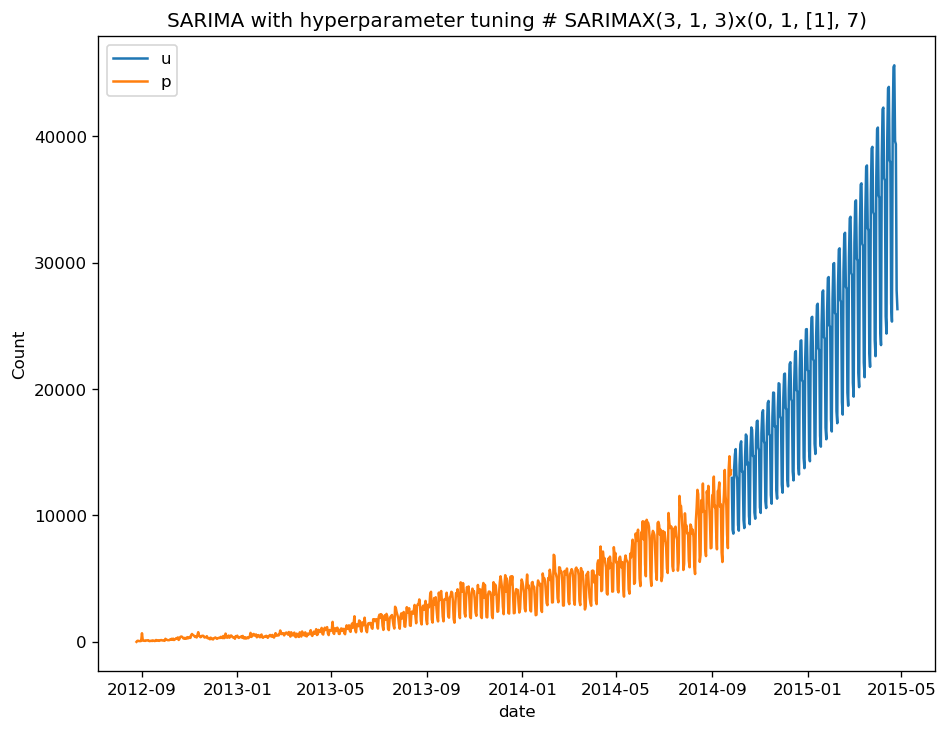

In [162]:
plt.plot(np.exp(a_preds_SARIMA_log_tuned),label='test')
plt.plot(np.exp(preds_old_SARIMA_log_tuned),label='train')
plt.legend('upperleft')
plt.xlabel('date')
plt.ylabel('Count')
plt.title('SARIMA with hyperparameter tuning # SARIMAX(3, 1, 3)x(0, 1, [1], 7)')
plt.show

# Hyperparameter tuning for SARIMA model with sqrt transformation

In [163]:
model = pm.auto_arima(np.sqrt(df.Count), start_p=1, start_q=1,
                         test='adf',
                         max_p=6, max_q=6, m=7,
                         start_P=0, seasonal=True,
                         d=1, D=1, trace=True,stationary=False,
                         error_action='ignore',  
                         suppress_warnings=True,with_intercept=False, 
                         stepwise=True)

Performing stepwise search to minimize aic
Fit ARIMA(1,1,1)x(0,1,1,7) [intercept=False]; AIC=4502.366, BIC=4520.868, Time=0.758 seconds
Fit ARIMA(0,1,0)x(0,1,0,7) [intercept=False]; AIC=5082.475, BIC=5087.100, Time=0.045 seconds
Fit ARIMA(1,1,0)x(1,1,0,7) [intercept=False]; AIC=4847.886, BIC=4861.762, Time=0.201 seconds
Fit ARIMA(0,1,1)x(0,1,1,7) [intercept=False]; AIC=4592.778, BIC=4606.654, Time=0.361 seconds
Fit ARIMA(1,1,1)x(0,1,0,7) [intercept=False]; AIC=4863.360, BIC=4877.236, Time=0.959 seconds
Near non-invertible roots for order (1, 1, 1)(0, 1, 0, 7); setting score to inf (at least one inverse root too close to the border of the unit circle: 1.000)
Fit ARIMA(1,1,1)x(1,1,1,7) [intercept=False]; AIC=4503.608, BIC=4526.735, Time=1.117 seconds
Fit ARIMA(1,1,1)x(0,1,2,7) [intercept=False]; AIC=4503.618, BIC=4526.745, Time=1.875 seconds
Fit ARIMA(1,1,1)x(1,1,0,7) [intercept=False]; AIC=4679.025, BIC=4697.526, Time=1.613 seconds
Near non-invertible roots for order (1, 1, 1)(1, 1, 0, 

In [164]:
mod = sm.tsa.statespace.SARIMAX(np.sqrt(df.Count), order=model.order, seasonal_order=model.seasonal_order)
results = mod.fit()
print(results.summary())

a_preds_SARIMA_sqrt_tuned = results.predict(start = 762, end= 974, dynamic= True)
preds_old_SARIMA_sqrt_tuned = results.predict(start = 0, end= 761, dynamic= False)
#print(a_preds.sum())

/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


                                     SARIMAX Results                                     
Dep. Variable:                             Count   No. Observations:                  762
Model:             SARIMAX(3, 1, 1)x(0, 1, 1, 7)   Log Likelihood               -2242.898
Date:                           Thu, 14 May 2020   AIC                           4497.795
Time:                                   17:53:44   BIC                           4525.548
Sample:                               08-25-2012   HQIC                          4508.486
                                    - 09-25-2014                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5048      0.033     15.407      0.000       0.441       0.569
ar.L2         -0.0798      0.043     -1.876

<function matplotlib.pyplot.show(*args, **kw)>

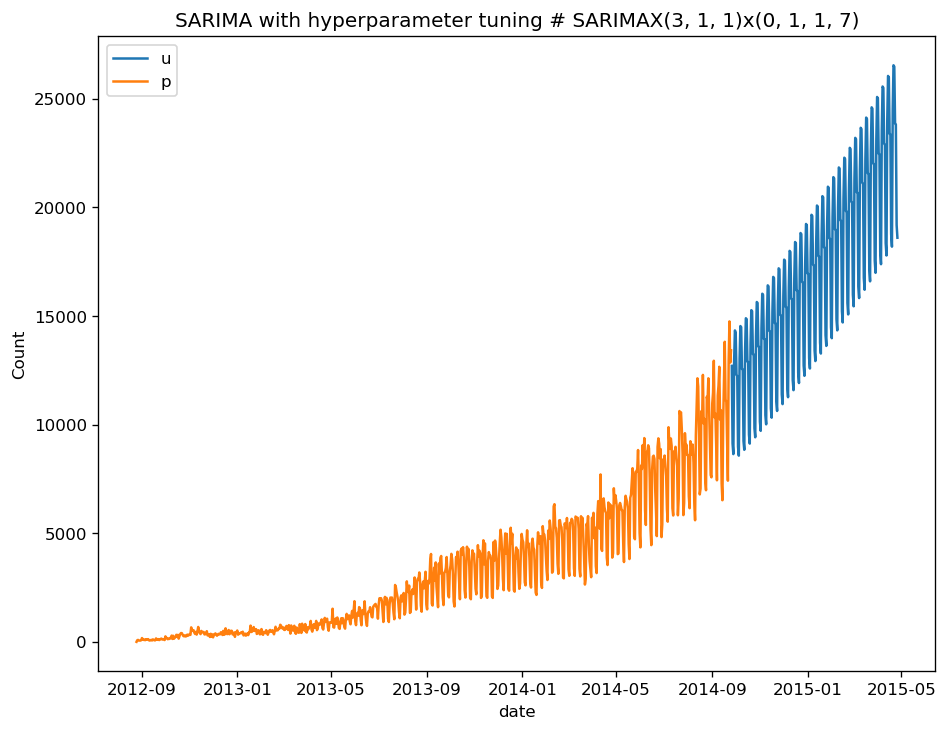

In [165]:
plt.plot(np.square(a_preds_SARIMA_sqrt_tuned),label='test')
plt.plot(np.square(preds_old_SARIMA_sqrt_tuned),label='train')
plt.legend('upperleft')
plt.xlabel('date')
plt.ylabel('Count')
plt.title('SARIMA with hyperparameter tuning # SARIMAX(3, 1, 1)x(0, 1, 1, 7)')
plt.show

# Converting daily data to hourly data using the mean distribution calculated above for SARIMA hyperparameter tuned (log transformation)

In [166]:
listm = list(sum2)
prediction = np.exp(a_preds_SARIMA_log_tuned)
er = []
#listm = [0.044286588,0.035343014,0.029911076,0.024714453,0.02080223,0.018621427,0.020023091,0.023221497,0.026741002,0.034555218,0.049047207,0.05437526,0.054951351,0.048600186,0.051965438,0.051309072,0.049999488,0.051164262,0.052423477,0.055626605,0.053455246,0.049894816,0.050075828,0.048892166]
for p in range(len(prediction)):
    for l in range(len(listm)):
        er.append(prediction[p]*listm[l])
d = {'Count': er}
predflog = pd.DataFrame(data=d)

In [167]:
sublog = pd.read_csv('../input/dataset2/sample_submission_LSeus50.csv')

sublog['Count'] = predflog['Count']

sublog.to_csv("submlog.csv",index=False)

# plot of hourly forecasting with log transformed data

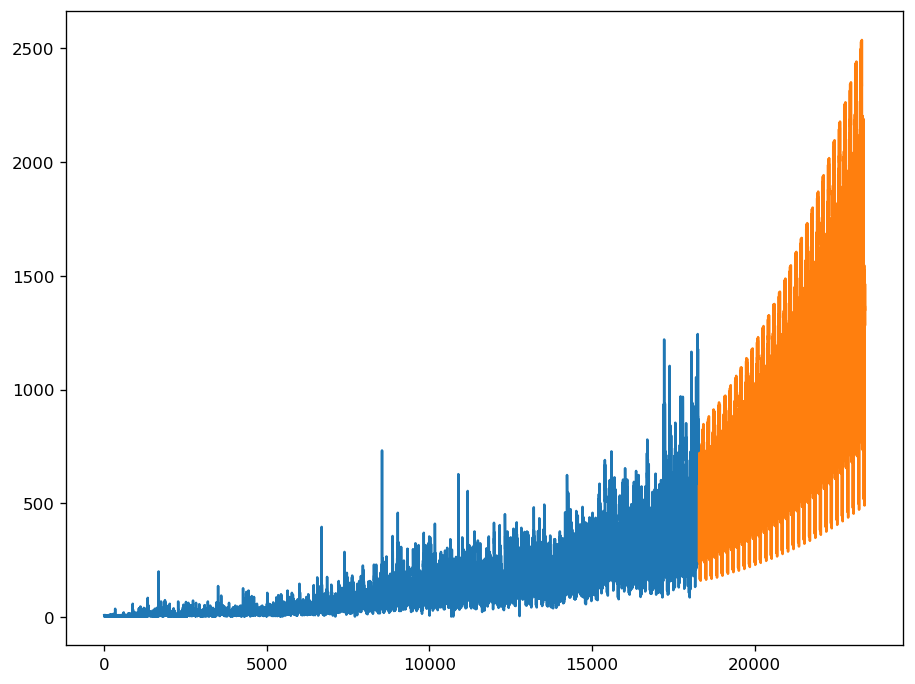

In [168]:
plt.plot(df1['Count'])
plt.plot(sublog['ID'],sublog['Count'])

# Ensembling sarima models (w/o transformation, square tranformation and exponential transformation #

In [169]:
ensembled_prediction = (a_preds_SARIMA_tuned+np.exp(a_preds_SARIMA_log_tuned)+np.square(a_preds_SARIMA_sqrt_tuned))/3

In [170]:
ensembled_prediction = (np.exp(a_preds_SARIMA_log_tuned))

<function matplotlib.pyplot.show(*args, **kw)>

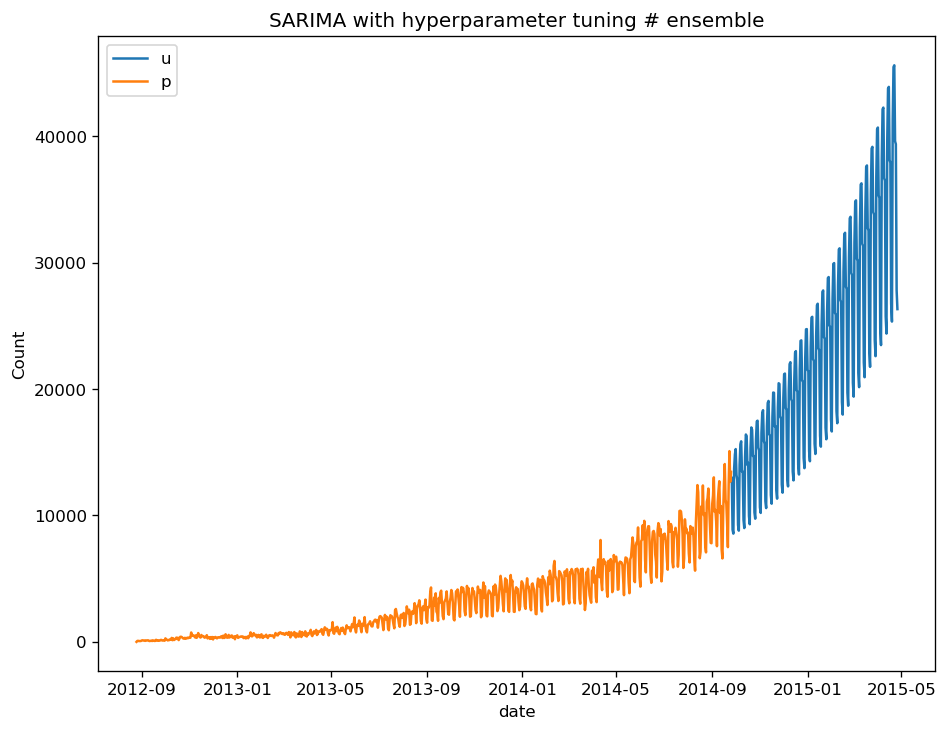

In [171]:
plt.plot(ensembled_prediction,label='test')
plt.plot(preds_old_SARIMA_tuned,label='train')
plt.legend('upperleft')
plt.xlabel('date')
plt.ylabel('Count')
plt.title('SARIMA with hyperparameter tuning # ensemble')
plt.show

# Converting daily data to hourly data using the mean distribution calculated above for ensembled data # 

In [172]:
listm = list(sum2)

er = []
#listm = [0.044286588,0.035343014,0.029911076,0.024714453,0.02080223,0.018621427,0.020023091,0.023221497,0.026741002,0.034555218,0.049047207,0.05437526,0.054951351,0.048600186,0.051965438,0.051309072,0.049999488,0.051164262,0.052423477,0.055626605,0.053455246,0.049894816,0.050075828,0.048892166]
for p in range(len(ensembled_prediction)):
    for l in range(len(listm)):
        er.append(ensembled_prediction[p]*listm[l])
d = {'Count': er}
predf = pd.DataFrame(data=d)

# plot of daily forecasting with ensembled data

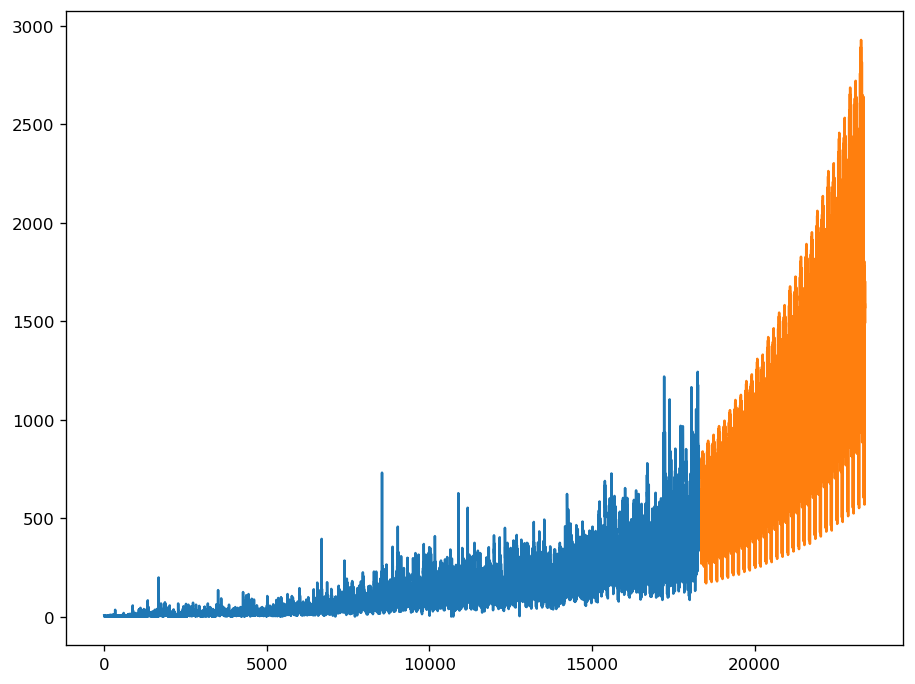

In [173]:
plt.plot(df1['Count'])
plt.plot(sub['ID'],sub['Count'])


In [174]:
sub = pd.read_csv('../input/dataset2/sample_submission_LSeus50.csv')

sub['Count'] = predf['Count']

sub.to_csv("subm.csv",index=False)

In [175]:
sub.head()

,ID,Count
0,18288,574.353525
1,18289,458.364162
2,18290,387.917261
3,18291,320.522174
4,18292,269.784482


# SARIMA Model hyper-parameter tuned model with log transformation performed the best with Root Mean Squre Error (RMSE) 146.9599 on test data  

# Now trying an ensemble of (1) SARIMA log transformed and (2) SARIMA seperatly on Trend (0,1,1),(0,1,1,30) and seasonality plus residuals (auto-arima hyperparameter tuning) on log transformed data..

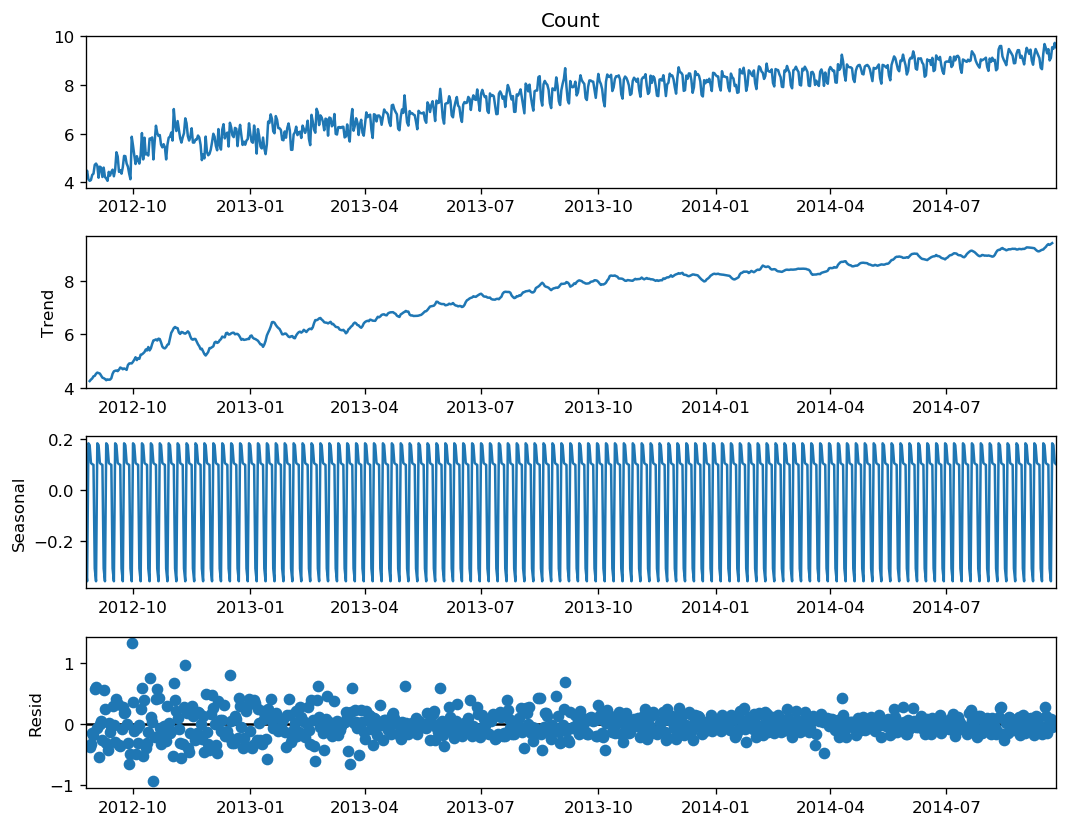

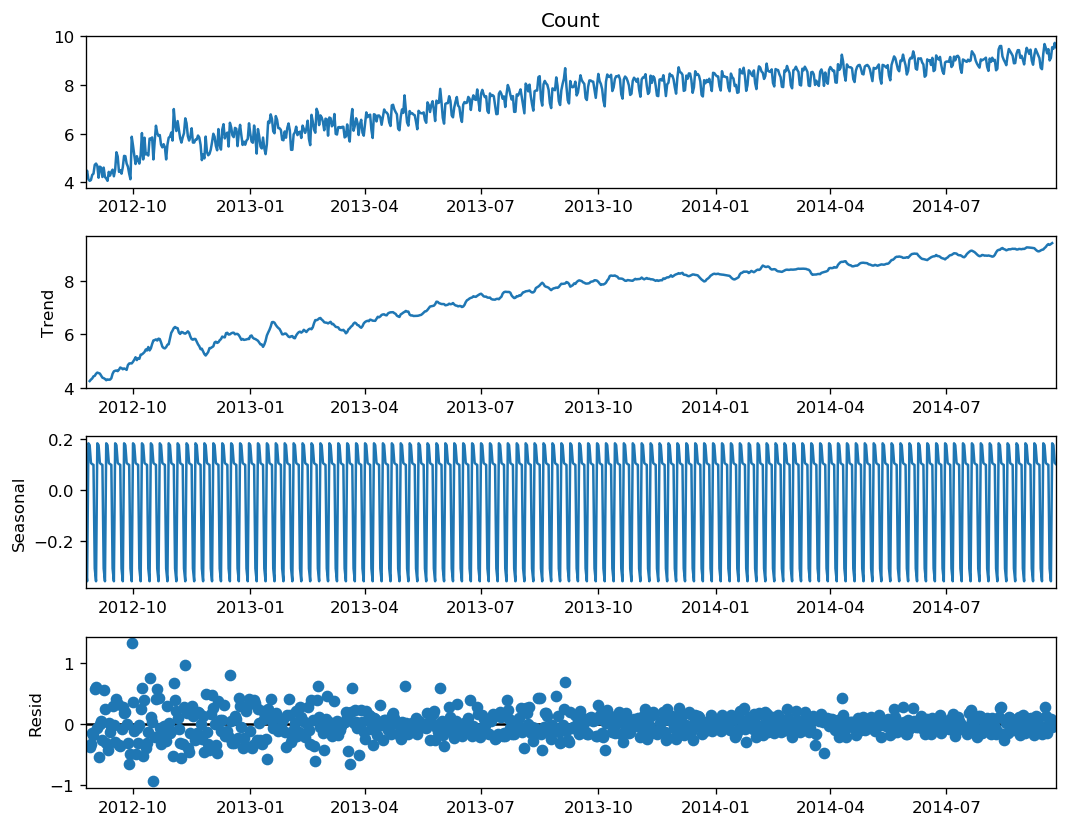

In [176]:
result = seasonal_decompose(np.log(df.Count), model='additive', period=7)

result.plot()

In [177]:
detrended_Data = (result.seasonal+result.resid).dropna()
trend_Data = result.trend.dropna()

In [178]:
trend_Data

date
2012-08-28    4.250109
2012-08-29    4.305505
2012-08-30    4.347411
2012-08-31    4.426697
2012-09-01    4.445155
                ...   
2014-09-18    9.341858
2014-09-19    9.381599
2014-09-20    9.354526
2014-09-21    9.384392
2014-09-22    9.420386
Name: trend, Length: 756, dtype: float64

/opt/conda/lib/python3.7/site-packages/statsmodels/regression/linear_model.py:1406: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


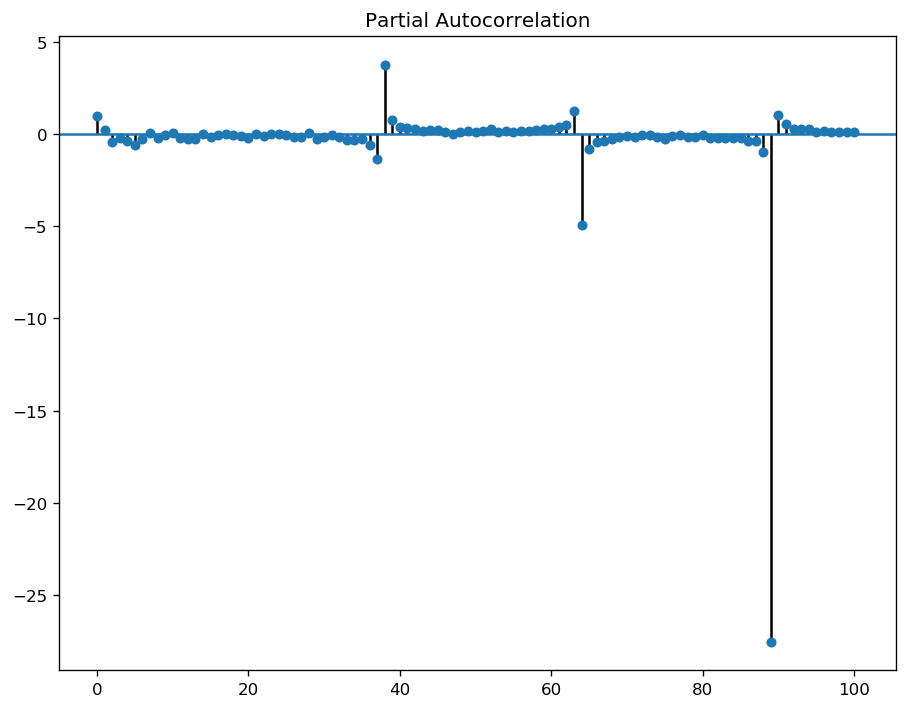

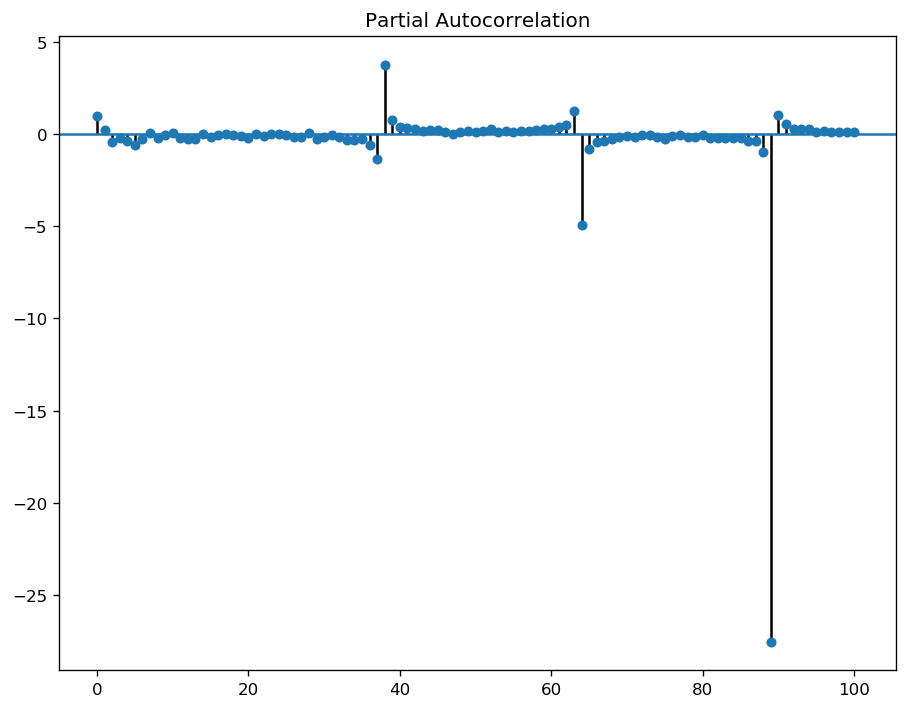

In [179]:
plot_pacf(detrended_Data.dropna(),lags=100)

In [181]:
model = pm.auto_arima(detrended_Data, start_p=1, start_q=1,
                         test='adf',
                         max_p=6, max_q=6, m=7,
                         start_P=0, seasonal=True,
                         d=1, D=1, trace=True,stationary=False,
                         error_action='ignore',  
                         suppress_warnings=True,with_intercept=False, 
                         stepwise=True)

Performing stepwise search to minimize aic
Fit ARIMA(1,1,1)x(0,1,1,7) [intercept=False]; AIC=-252.070, BIC=-233.600, Time=1.862 seconds
Fit ARIMA(0,1,0)x(0,1,0,7) [intercept=False]; AIC=620.584, BIC=625.201, Time=0.053 seconds
Fit ARIMA(1,1,0)x(1,1,0,7) [intercept=False]; AIC=342.316, BIC=356.168, Time=0.272 seconds
Fit ARIMA(0,1,1)x(0,1,1,7) [intercept=False]; AIC=-249.962, BIC=-236.110, Time=2.297 seconds
Near non-invertible roots for order (0, 1, 1)(0, 1, 1, 7); setting score to inf (at least one inverse root too close to the border of the unit circle: 1.000)
Fit ARIMA(1,1,1)x(0,1,0,7) [intercept=False]; AIC=138.124, BIC=151.976, Time=1.034 seconds
Near non-invertible roots for order (1, 1, 1)(0, 1, 0, 7); setting score to inf (at least one inverse root too close to the border of the unit circle: 1.000)
Fit ARIMA(1,1,1)x(1,1,1,7) [intercept=False]; AIC=-250.380, BIC=-227.293, Time=2.928 seconds
Near non-invertible roots for order (1, 1, 1)(1, 1, 1, 7); setting score to inf (at least

In [191]:
mod = sm.tsa.statespace.SARIMAX(detrended_Data, order=model.order, seasonal_order=model.seasonal_order)
results = mod.fit()
print(results.summary())

a_preds_SARIMA_log_tunedm = results.predict(start = 759, end= 971, dynamic= True)
preds_old_SARIMA_log_tunedm = results.predict(start = 0, end= 759, dynamic= False)
#print(a_preds.sum())

/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/statespace/kalman_filter.py:2014: ValueWarning: Dynamic prediction specified to begin during out-of-sample forecasting period, and so has no effect.
  ' effect.', ValueWarning)


                                      SARIMAX Results                                      
Dep. Variable:                                   y   No. Observations:                  756
Model:             SARIMAX(2, 1, 2)x(0, 1, [1], 7)   Log Likelihood                 297.225
Date:                             Thu, 14 May 2020   AIC                           -582.450
Time:                                     18:00:07   BIC                           -554.746
Sample:                                 08-28-2012   HQIC                          -571.774
                                      - 09-22-2014                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7519      0.025     30.684      0.000       0.704       0.800
ar.L2         -0.5350      

In [192]:
mod = sm.tsa.statespace.SARIMAX(trend_Data, order=(1,1,0), seasonal_order=(0,1,1,30))
results = mod.fit()
print(results.summary())

a_preds_SARIMA_log_tunedmt = results.predict(start = 759, end= 971, dynamic= True)
preds_old_SARIMA_log_tunedmt = results.predict(start = 0, end= 759, dynamic= False)
#print(a_preds.sum())

/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


                                      SARIMAX Results                                       
Dep. Variable:                                trend   No. Observations:                  756
Model:             SARIMAX(1, 1, 0)x(0, 1, [1], 30)   Log Likelihood                1205.437
Date:                              Thu, 14 May 2020   AIC                          -2404.874
Time:                                      18:00:29   BIC                          -2391.115
Sample:                                  08-28-2012   HQIC                         -2399.564
                                       - 09-22-2014                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4315      0.027     16.111      0.000       0.379       0.484
ma.S.L30      -0.95

/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/statespace/kalman_filter.py:2014: ValueWarning: Dynamic prediction specified to begin during out-of-sample forecasting period, and so has no effect.
  ' effect.', ValueWarning)


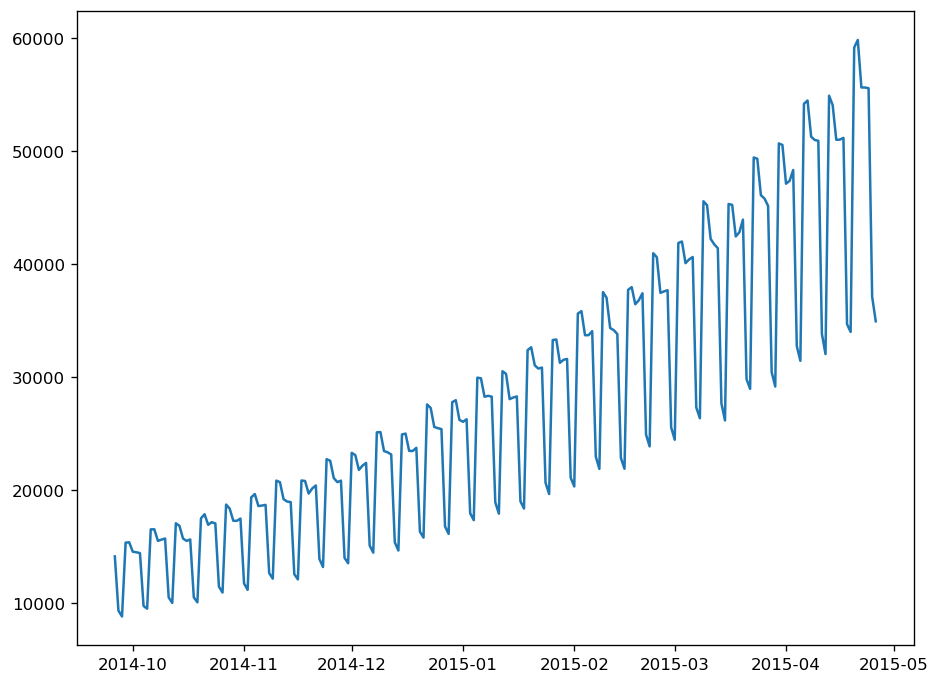

In [210]:
plt.plot(np.exp(a_preds_SARIMA_log_tunedmt+a_preds_SARIMA_log_tunedm))

<function matplotlib.pyplot.show(*args, **kw)>

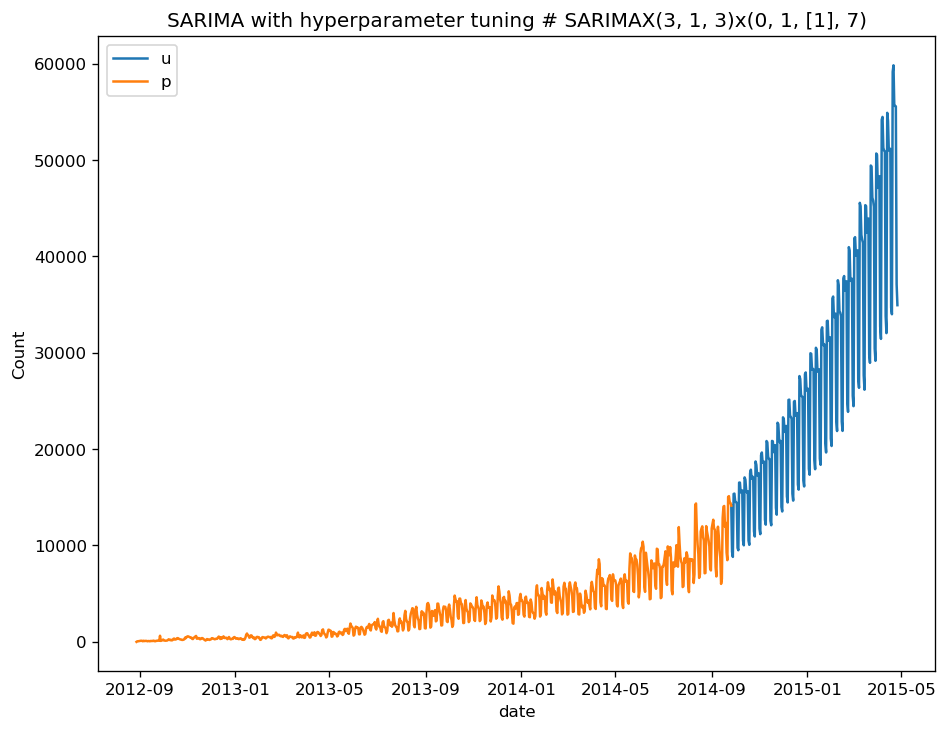

In [193]:
plt.plot(np.exp(a_preds_SARIMA_log_tunedm+a_preds_SARIMA_log_tunedmt),label='test')
plt.plot(np.exp(preds_old_SARIMA_log_tunedm+preds_old_SARIMA_log_tunedmt),label='train')
plt.legend('upperleft')
plt.xlabel('date')
plt.ylabel('Count')
plt.title('SARIMA with hyperparameter tuning # SARIMAX(3, 1, 3)x(0, 1, [1], 7)')
plt.show

In [194]:
ensembled_prediction1 = (np.exp(a_preds_SARIMA_log_tunedm+a_preds_SARIMA_log_tunedmt)+np.exp(a_preds_SARIMA_log_tuned))/2

<function matplotlib.pyplot.show(*args, **kw)>

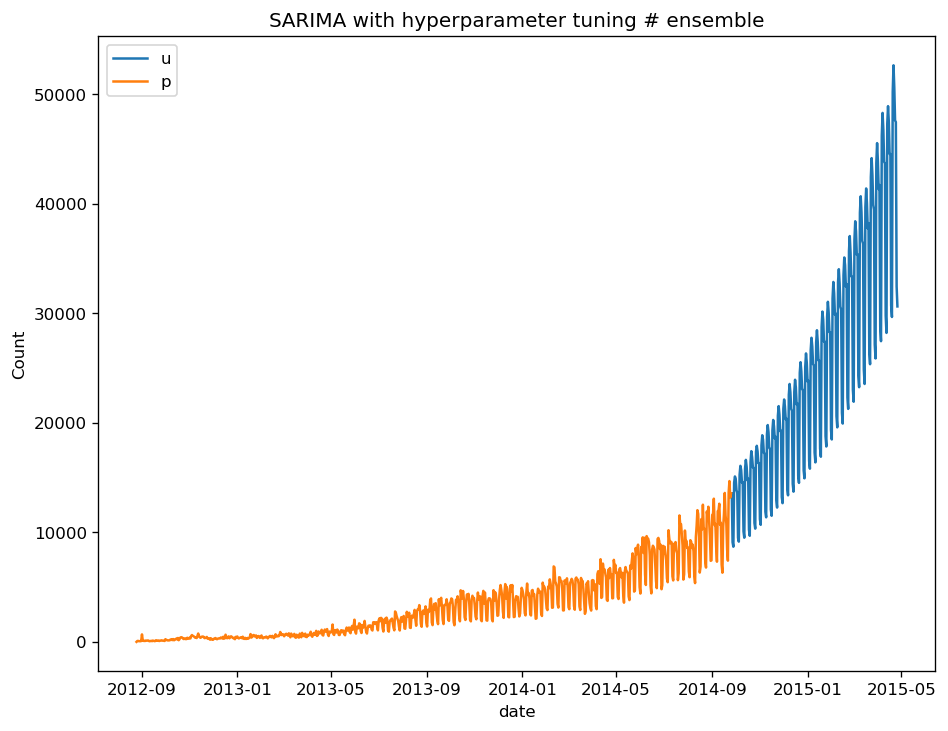

In [196]:
plt.plot(ensembled_prediction1,label='test')
plt.plot(np.exp(preds_old_SARIMA_log_tuned),label='train')
plt.legend('upperleft')
plt.xlabel('date')
plt.ylabel('Count')
plt.title('SARIMA with hyperparameter tuning # ensemble')
plt.show

In [197]:
listm = list(sum2)

er = []
#listm = [0.044286588,0.035343014,0.029911076,0.024714453,0.02080223,0.018621427,0.020023091,0.023221497,0.026741002,0.034555218,0.049047207,0.05437526,0.054951351,0.048600186,0.051965438,0.051309072,0.049999488,0.051164262,0.052423477,0.055626605,0.053455246,0.049894816,0.050075828,0.048892166]
for p in range(len(ensembled_prediction1)):
    for l in range(len(listm)):
        er.append(ensembled_prediction1[p]*listm[l])
d = {'Count': er}
predf = pd.DataFrame(data=d)

In [198]:
sub = pd.read_csv('../input/dataset2/sample_submission_LSeus50.csv')

sub['Count'] = predf['Count']

sub.to_csv("subm.csv",index=False)

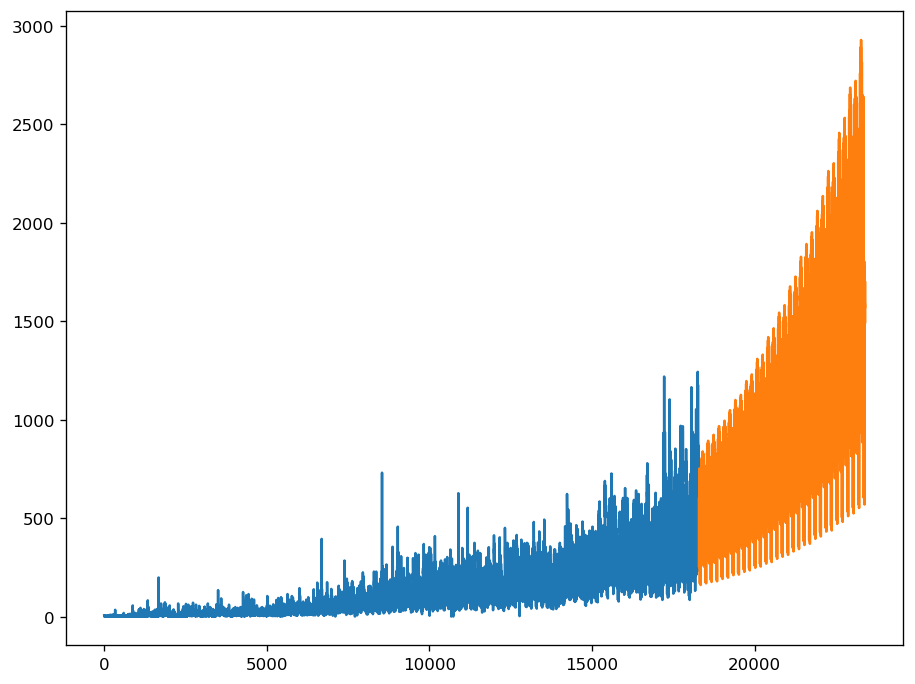

In [199]:
plt.plot(df1['Count'])
plt.plot(sub['ID'],sub['Count'])


# This ensemble performs even better on test data with 144.1 RMSE (public score)